In [14]:
import pandas as pd
import numpy as np

In [15]:
import gc
from tqdm import tqdm
import sys

from google.colab import drive
drive.mount('/content/drive')
tqdm.pandas()
sys.path.append('../')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Gender

In [16]:
item = pd.read_csv('/content/drive/MyDrive/newT/datasets/articles.csv')

In [17]:
def set_gender_flg(x):
    female_pro_types = [
        "Bra",
        "Underwear Tights",
        "Leggings/Tights",
        "Hair clip",
        "Hair string",
        "Hair/alice band",
        "Bikini top",
        "Skirt",
        "Dress",
        "Earring",
        "Alice band",
        "Straw hat",
        "Necklace",
        "Ballerinas",
        "Blouse",
        "Beanie",
        "Giftbox",
        "Pumps",
        "Bootie",
        "Heeled sandals",
        "Nipple covers",
        "Hair ties",
        "Underwear corset",
        "Bra extender",
        "Underdress",
        "Underwear set",
        "Sarong",
        "Leg warmers",
        "Hairband",
        "Tote bag",
        "Earrings",
        "Flat shoes",
        "Heels",
        "Cap",
        "Shoulder bag",
        "Headband",
        "Baby Bib",
        "Cross-body bag",
        "Bumbag",
    ]
    x["gender"] = 0 # * 0 for not divided, 1 for male, 2 for female
    if x["index_group_name"] == "Ladieswear":
        x["gender"] = 2
    elif x["index_group_name"] == "Menswear":
        x["gender"] = 1
    else:
        if (
            "boy" in x["department_name"].lower()
            or "men" in x["department_name"].lower()
        ):
            x["gender"] = 1
        if (
            "girl" in x["department_name"].lower()
            or "ladies" in x["department_name"].lower()
            or x["product_type_name"] in female_pro_types
        ):
            x["gender"] = 2
    return x

In [18]:
item = item.progress_apply(set_gender_flg, axis=1)

100%|██████████| 105542/105542 [01:08<00:00, 1530.39it/s]


In [19]:
trans = pd.read_csv('/content/drive/MyDrive/newT/datasets/transactions_train.csv')
trans['t_dat'] = pd.to_datetime(trans['t_dat'])
trans['YYYY_MM'] = trans['t_dat'].dt.year.astype(str) + '_' + trans['t_dat'].dt.month.astype(str)
# trans['week'] = (trans['t_dat'] - trans['t_dat'].min()).dt.days // 7
trans = pd.merge(trans, item[['article_id','gender','product_type_name']], on='article_id', how='left')
del item
gc.collect()

0

In [20]:
user = pd.read_csv('/content/drive/MyDrive/newT/datasets/customers.csv')
trans = trans.merge(user[['customer_id','postal_code']], on='customer_id', how='left')
del user
gc.collect()

24

In [21]:
ttl_cnt = trans.groupby(['customer_id']).size().reset_index(name='ttl_cnt')
gender_sale = trans.groupby(['customer_id','gender']).size().reset_index(name='cnt')
gender_sale = gender_sale.merge(ttl_cnt, on=['customer_id'], how='left')
gender_sale['ratio'] = gender_sale['cnt'] / gender_sale['ttl_cnt']

In [22]:
gender_sale = pd.pivot_table(gender_sale, values='ratio', index='customer_id', columns=['gender'])
gender_sale = gender_sale.reset_index()
gender_sale = gender_sale.fillna(0)

In [23]:
gender_sale['gender'] = 0
gender_sale.loc[gender_sale[1]>=0.8, 'gender'] = 1
gender_sale.loc[gender_sale[2]>=0.8, 'gender'] = 2

<Axes: >

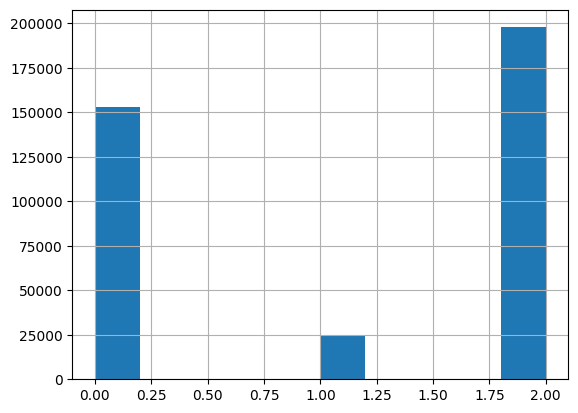

In [24]:
gender_sale['gender'].hist()

### Sale Trend

In [25]:
ttl_sale = trans.groupby('product_type_name').size().reset_index(name='ttl_sale')
month_sale = trans.groupby(['YYYY_MM','product_type_name']).size().reset_index(name='month_sale')
month_sale = month_sale.merge(ttl_sale, on=['product_type_name'], how='left')
month_sale['sale_ratio'] = month_sale['month_sale'] / month_sale['ttl_sale']
# week_sale = trans.groupby(['week','product_type_name']).size().reset_index(name='week_sale')
# week_sale = week_sale.merge(ttl_sale, on=['product_type_name'], how='left')
# week_sale['sale_ratio'] = week_sale['week_sale'] / week_sale['ttl_sale']

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

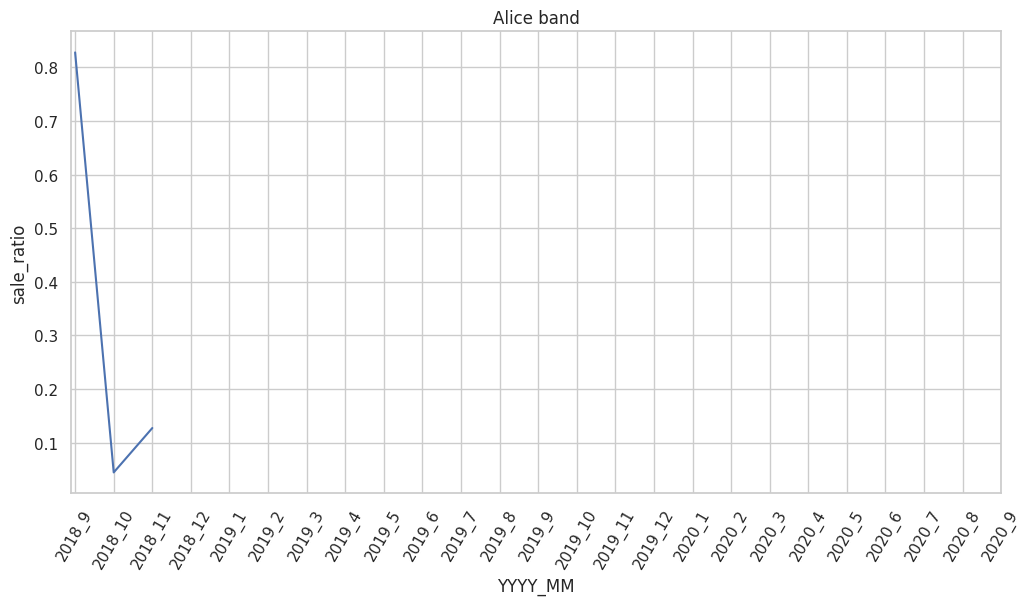

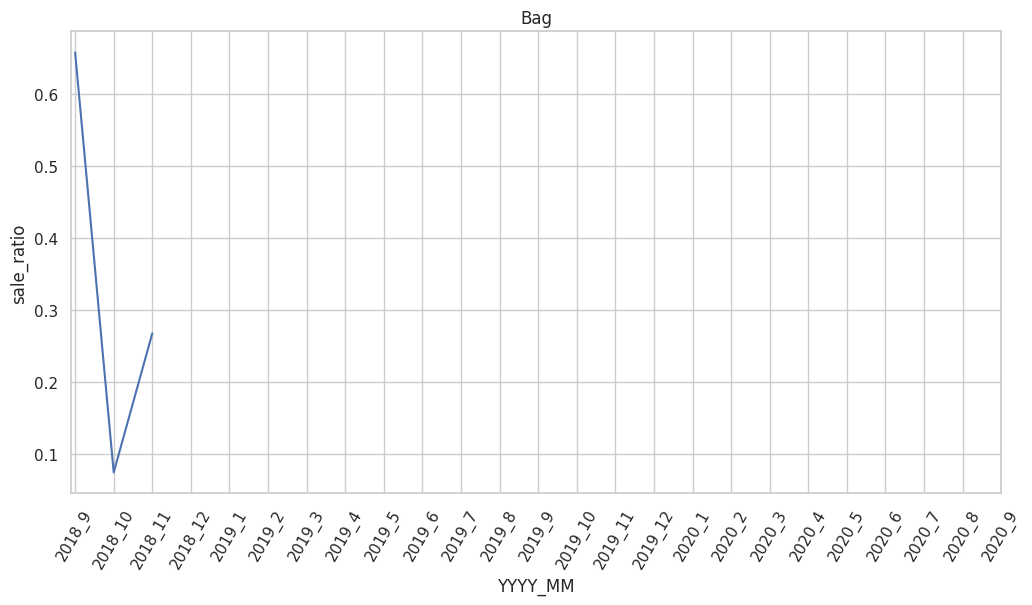

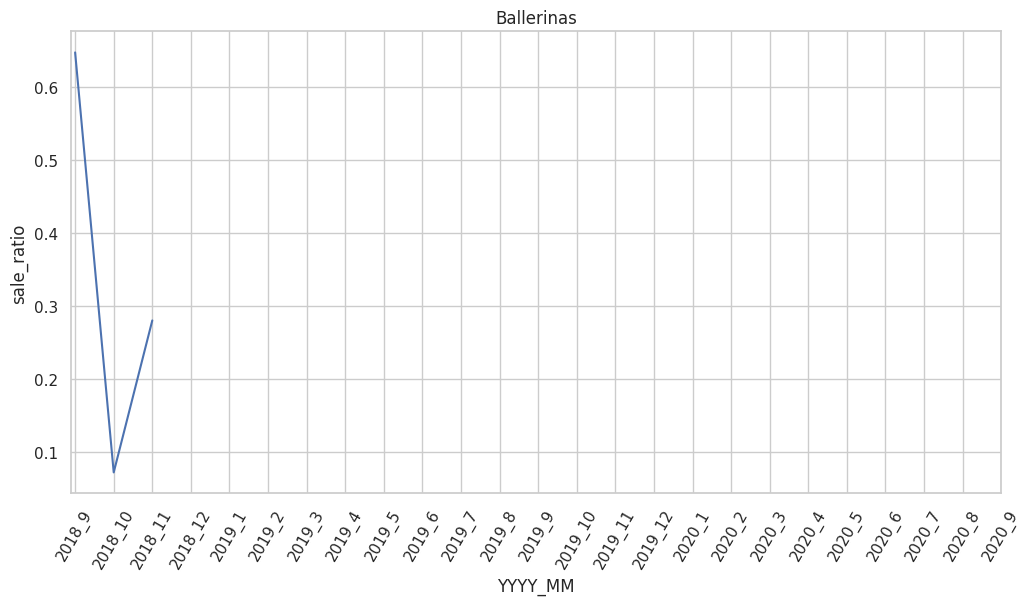

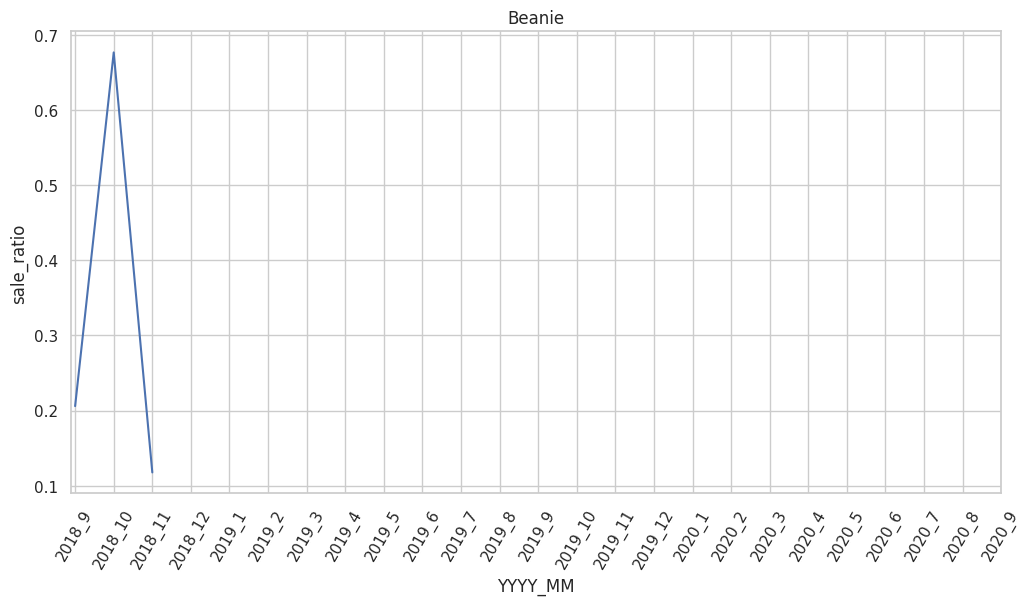

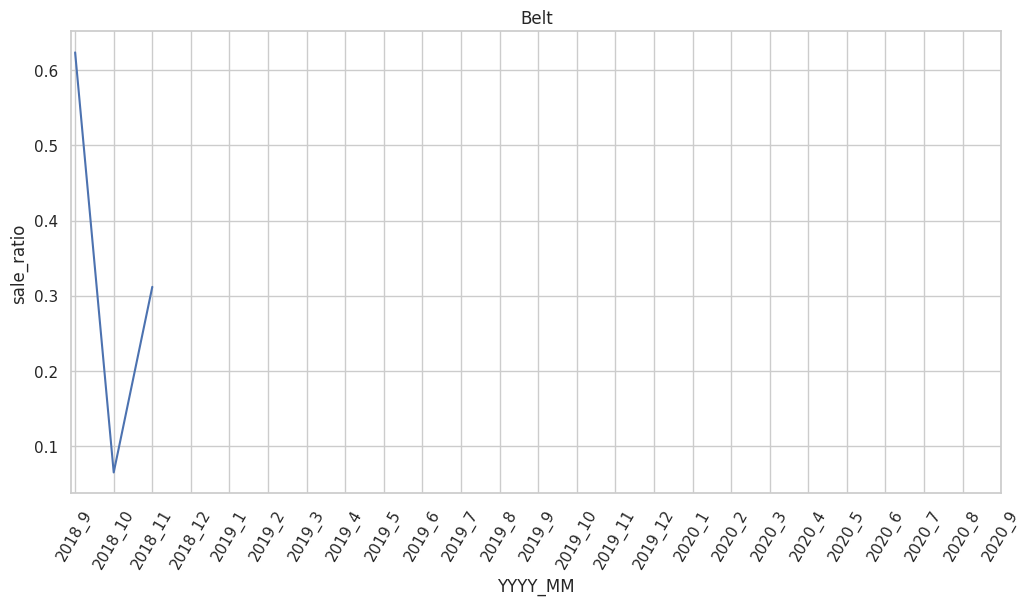

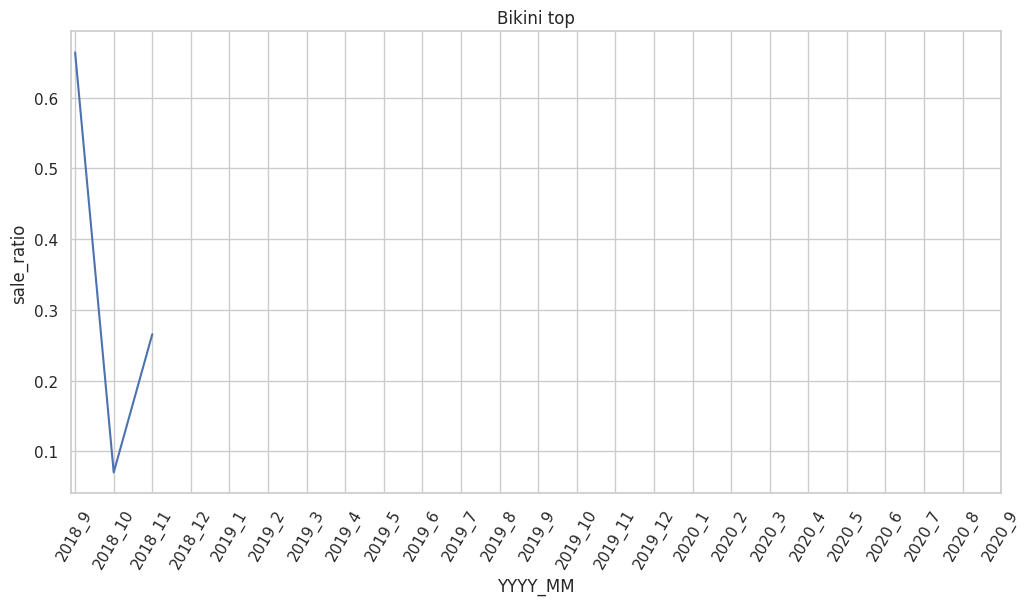

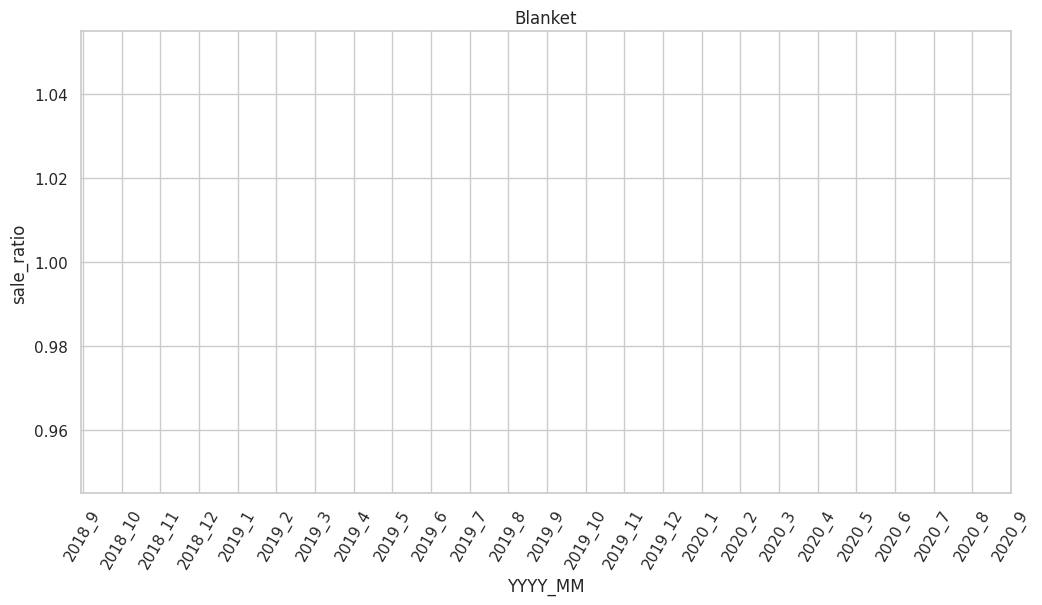

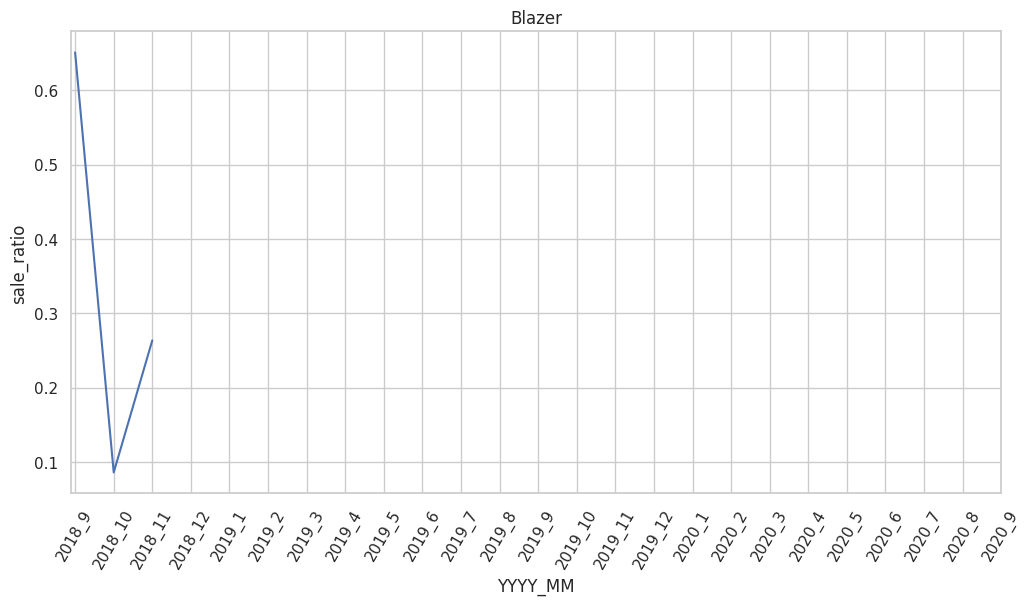

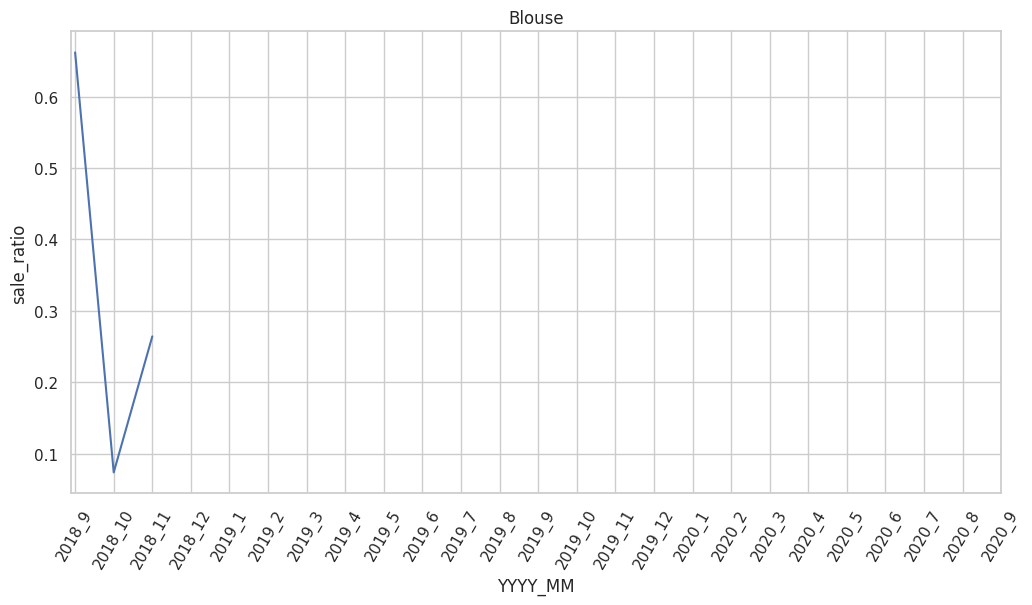

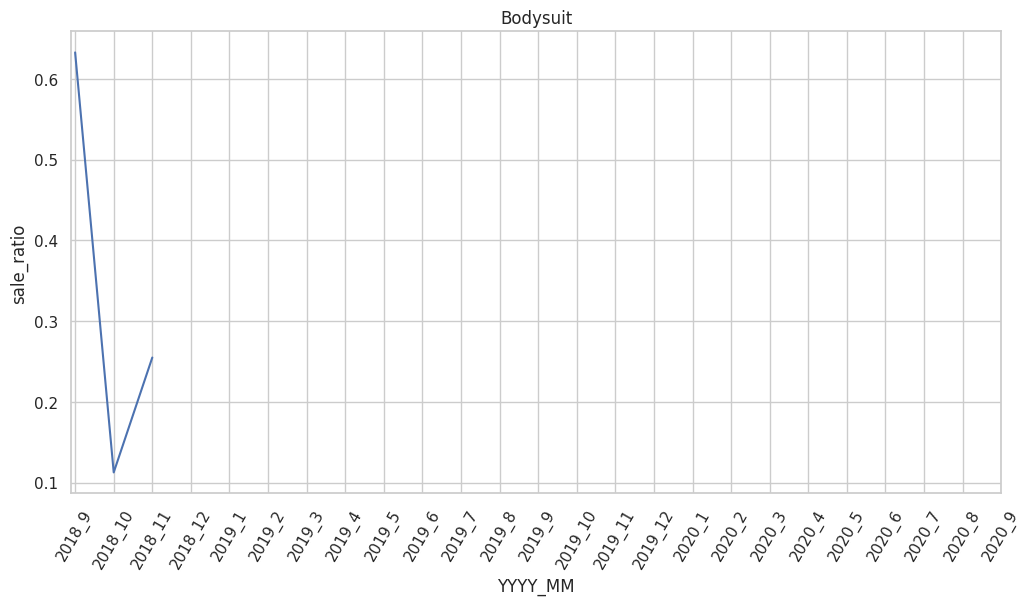

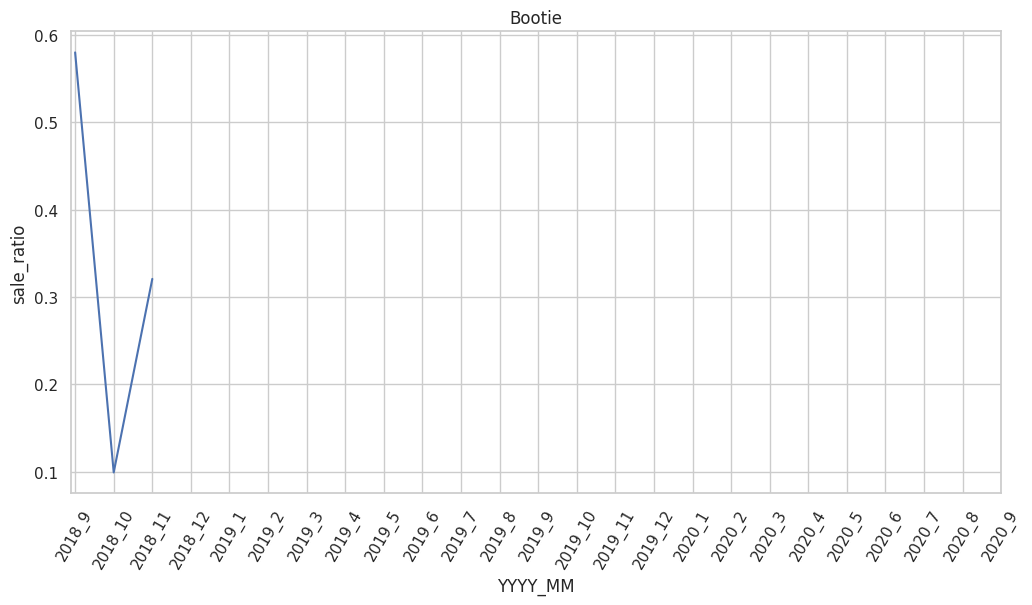

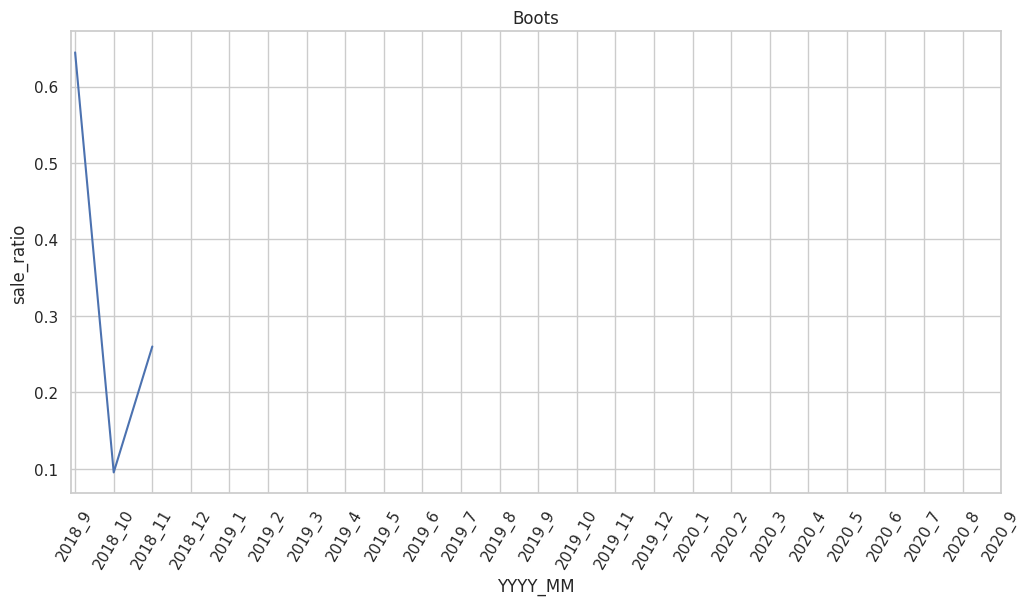

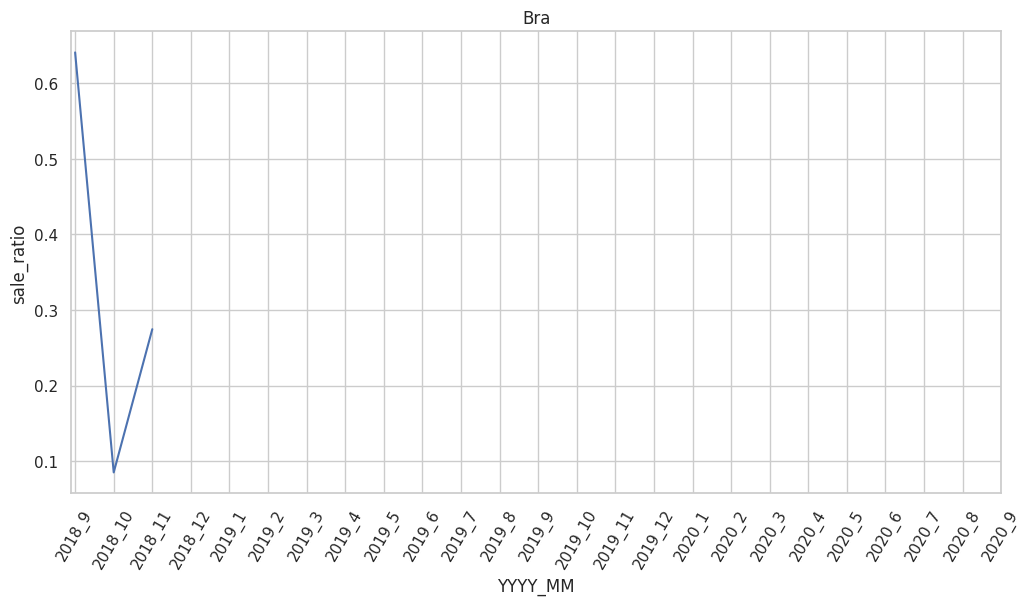

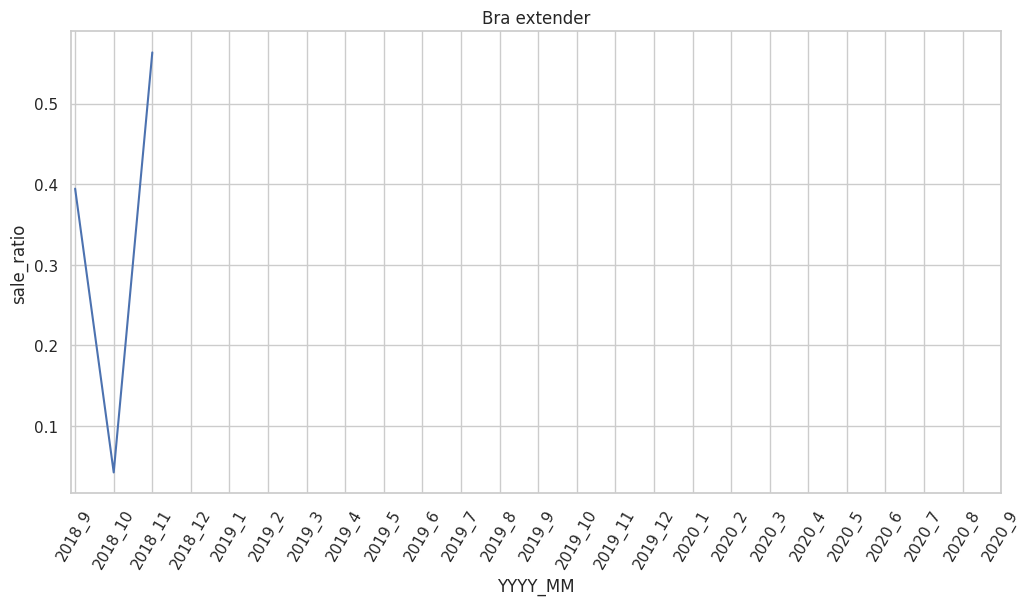

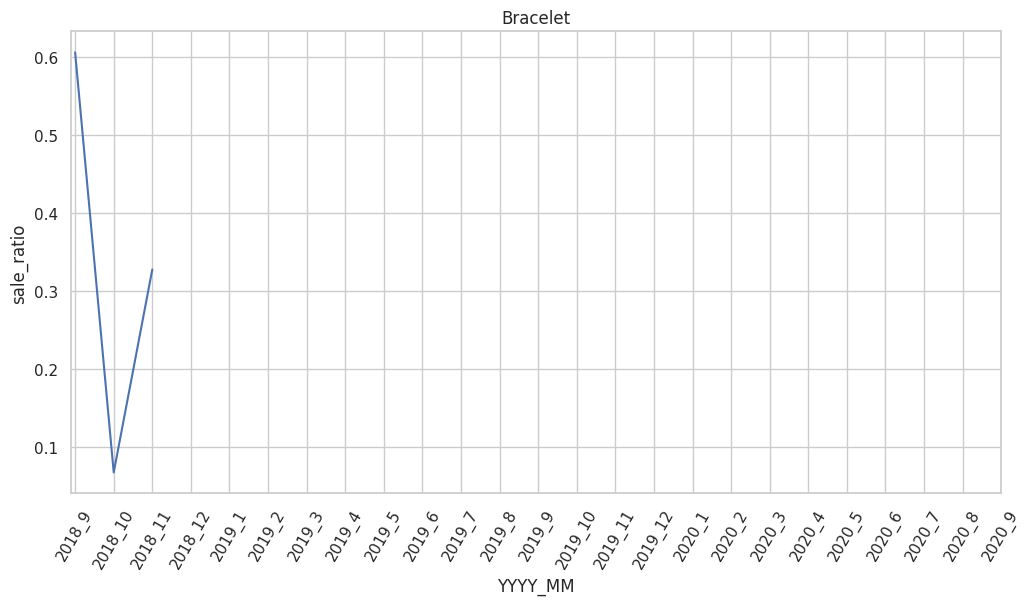

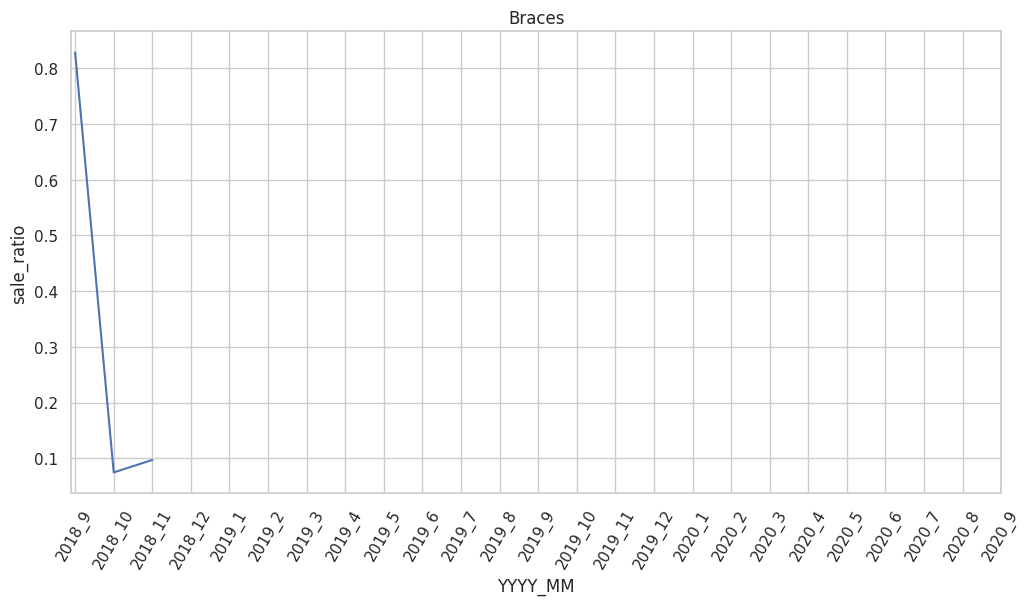

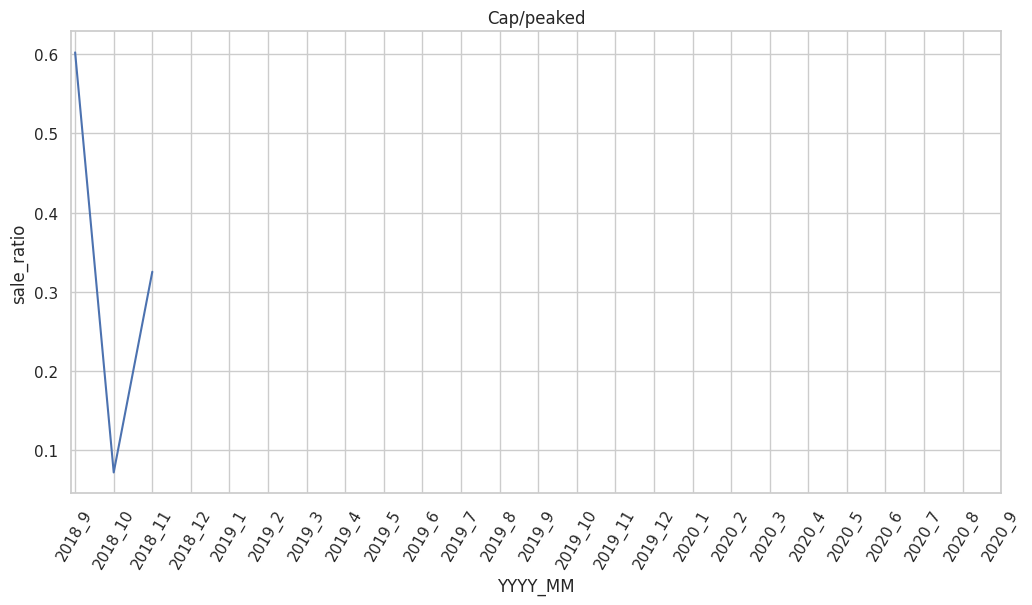

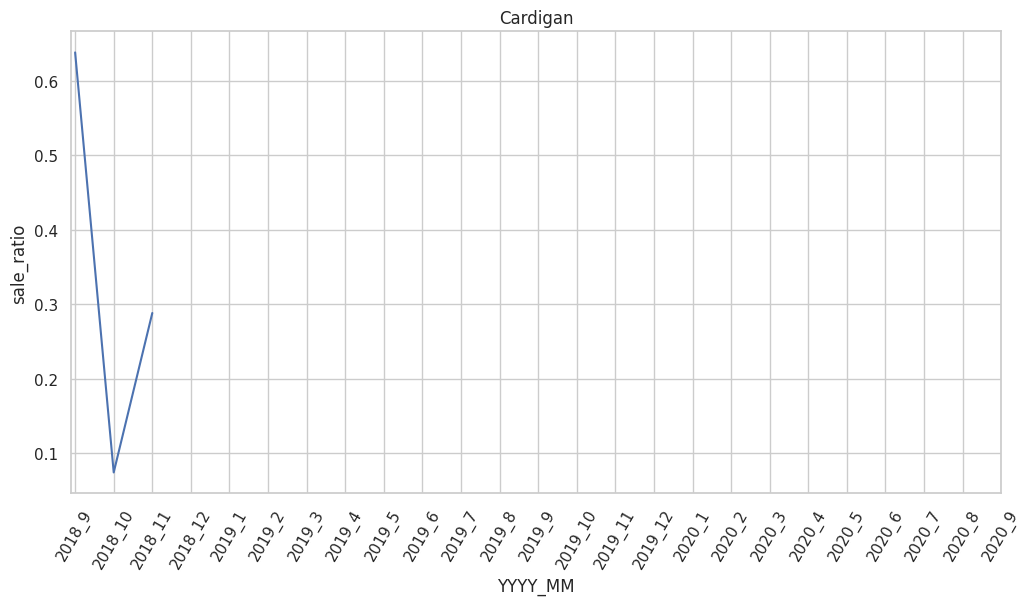

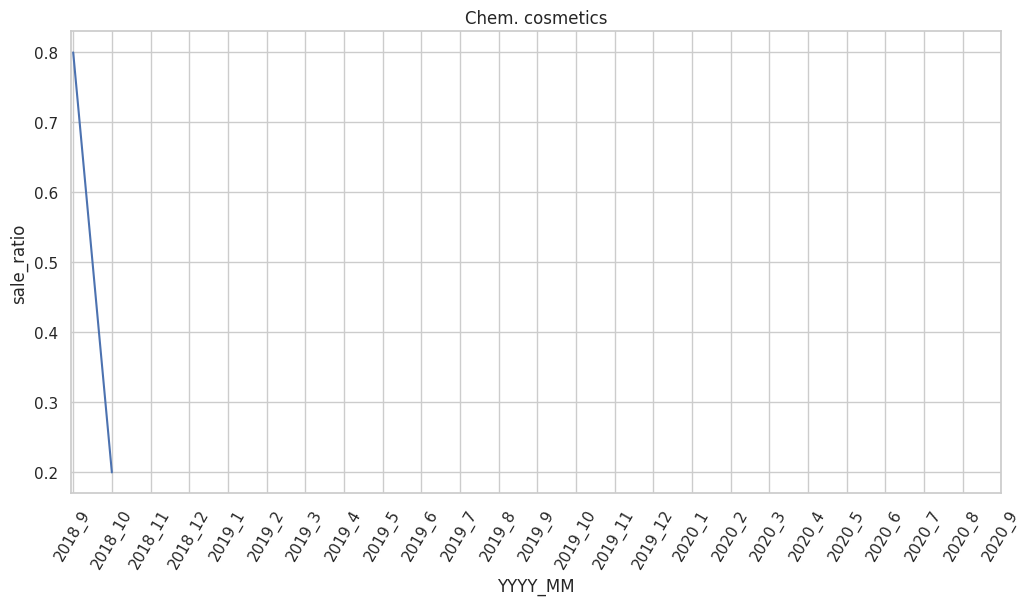

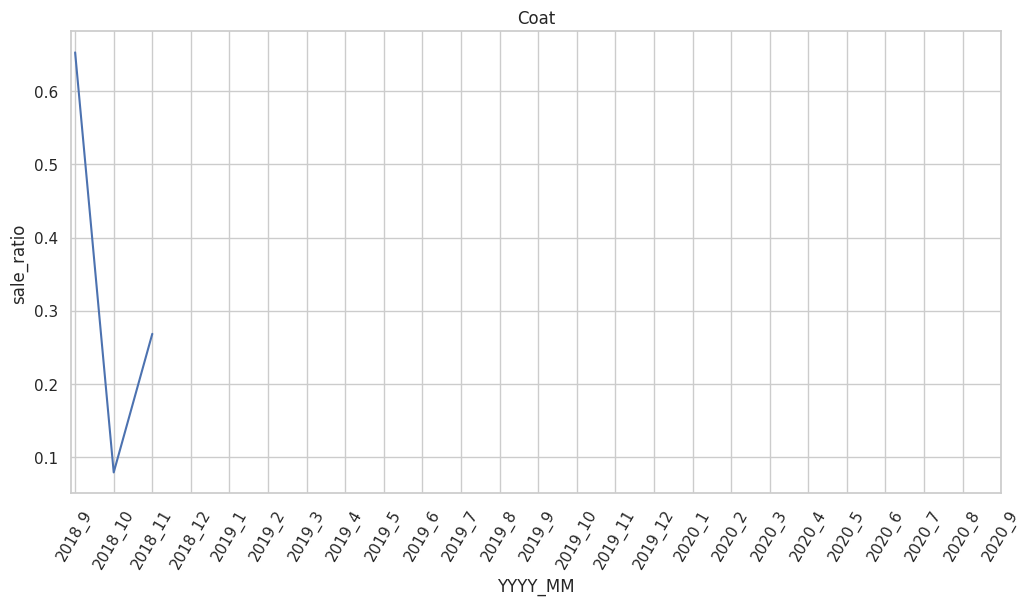

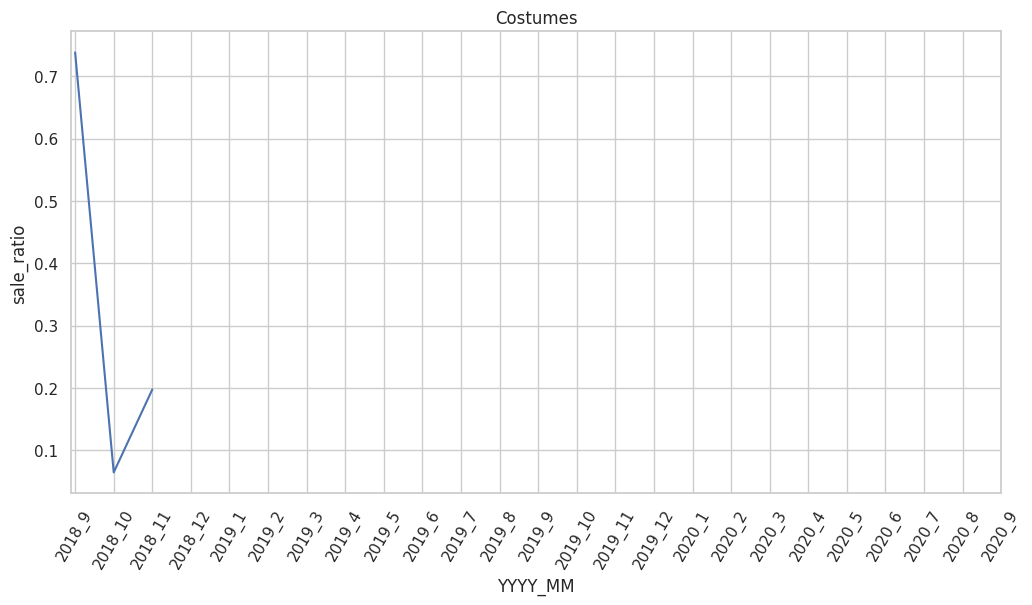

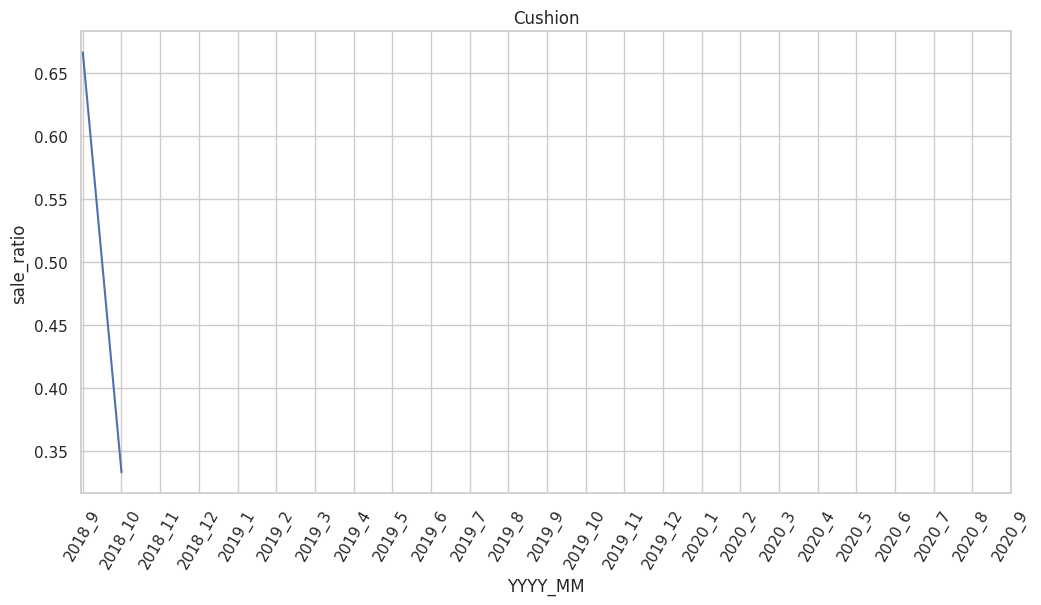

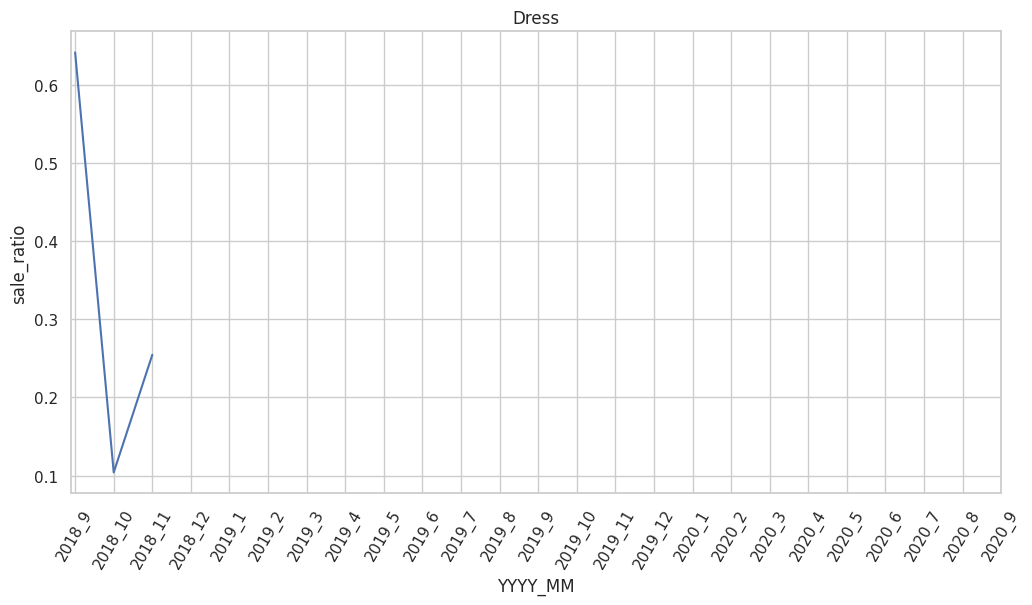

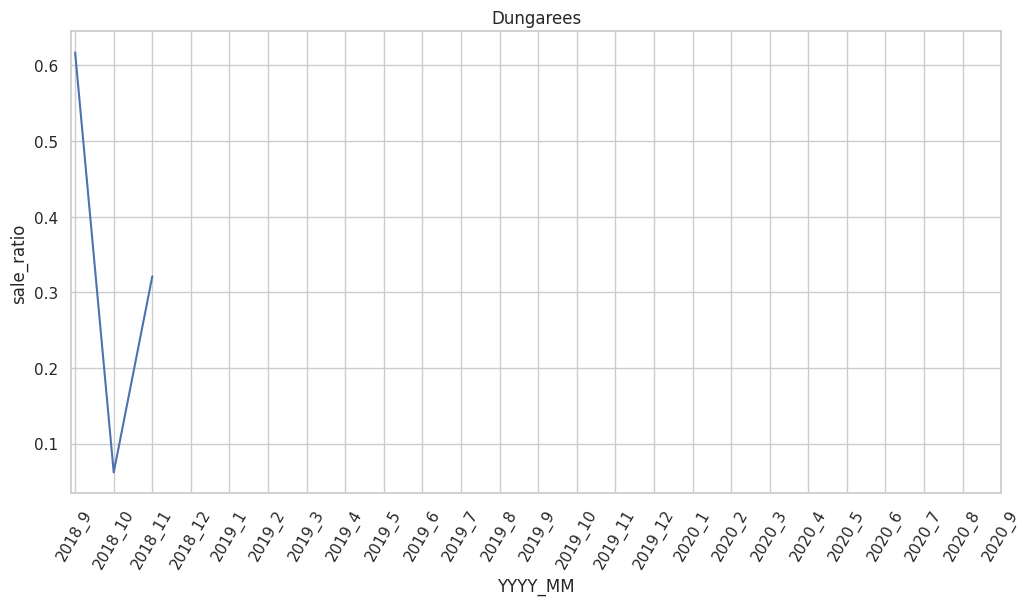

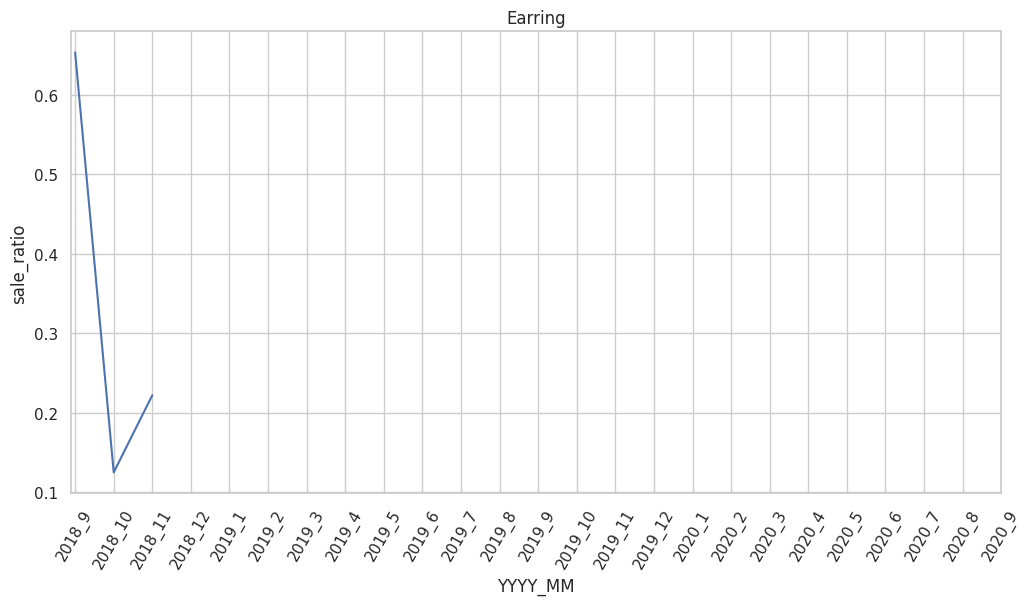

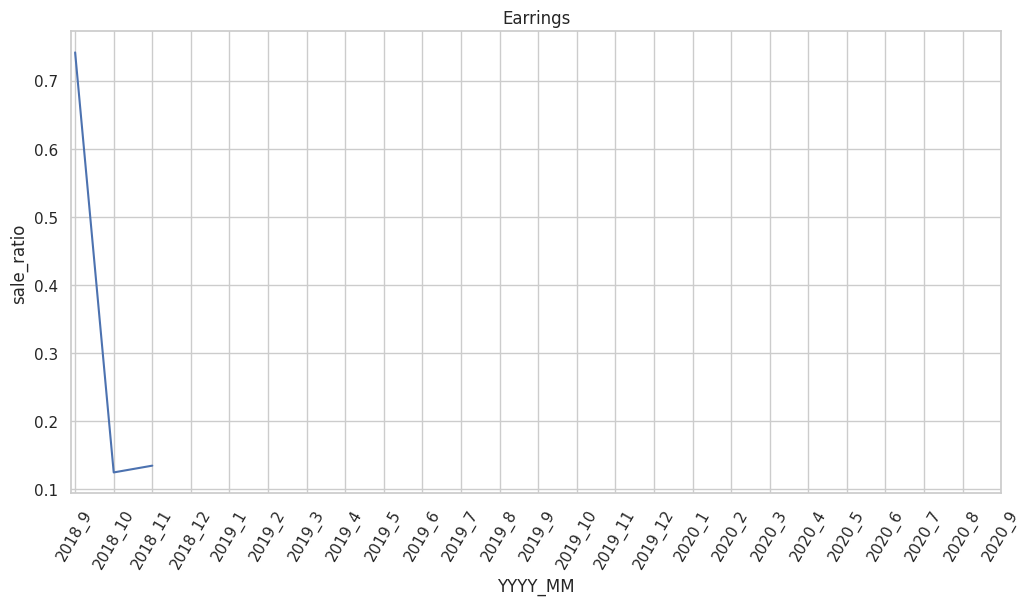

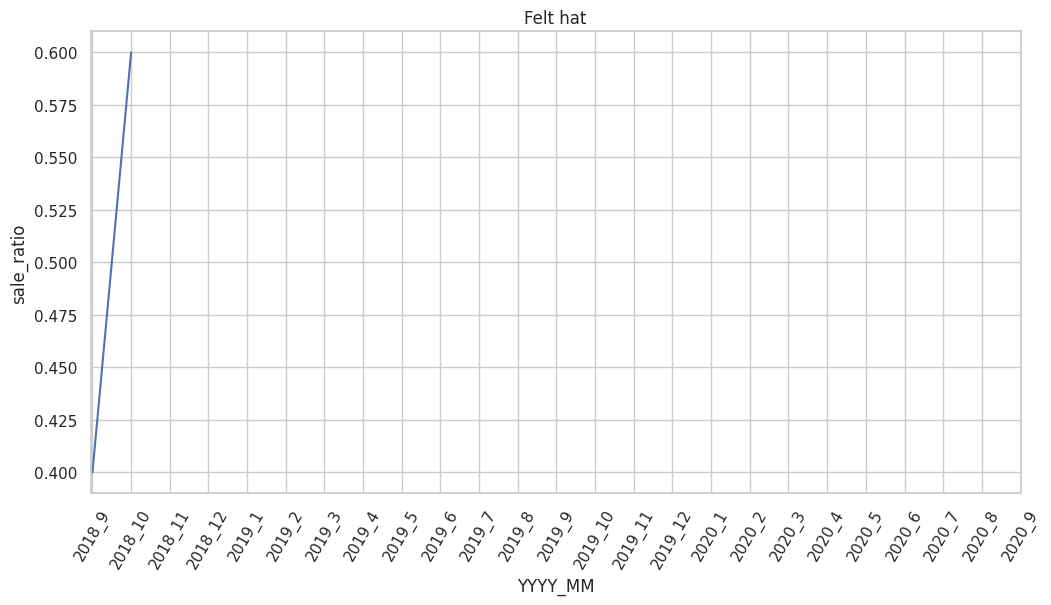

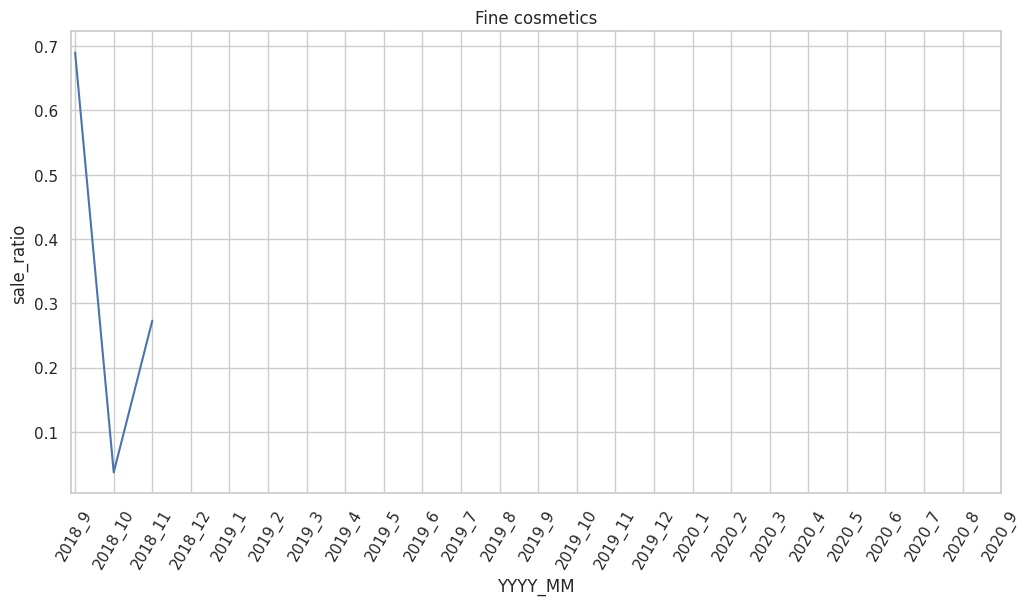

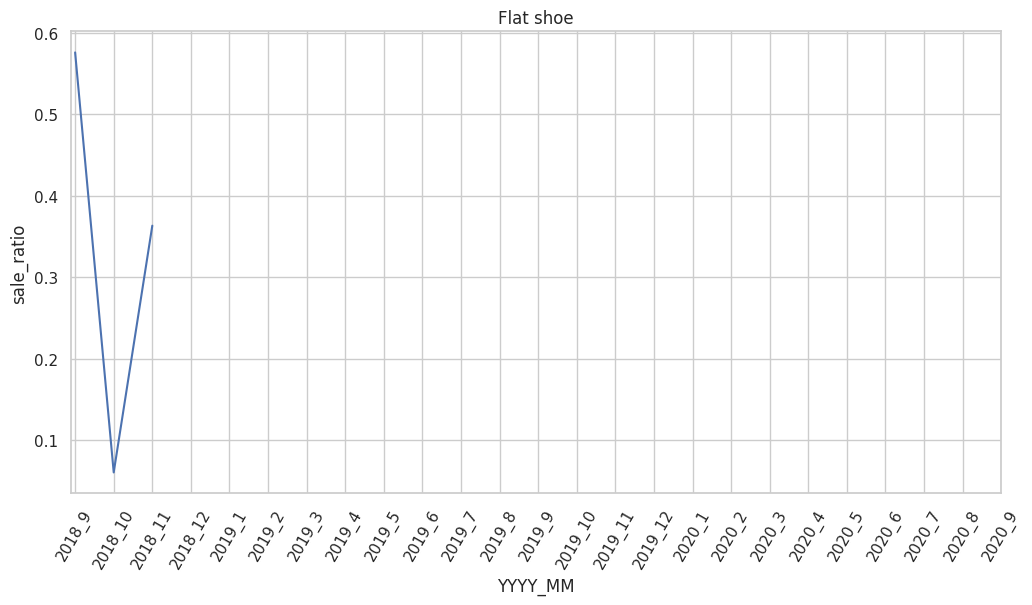

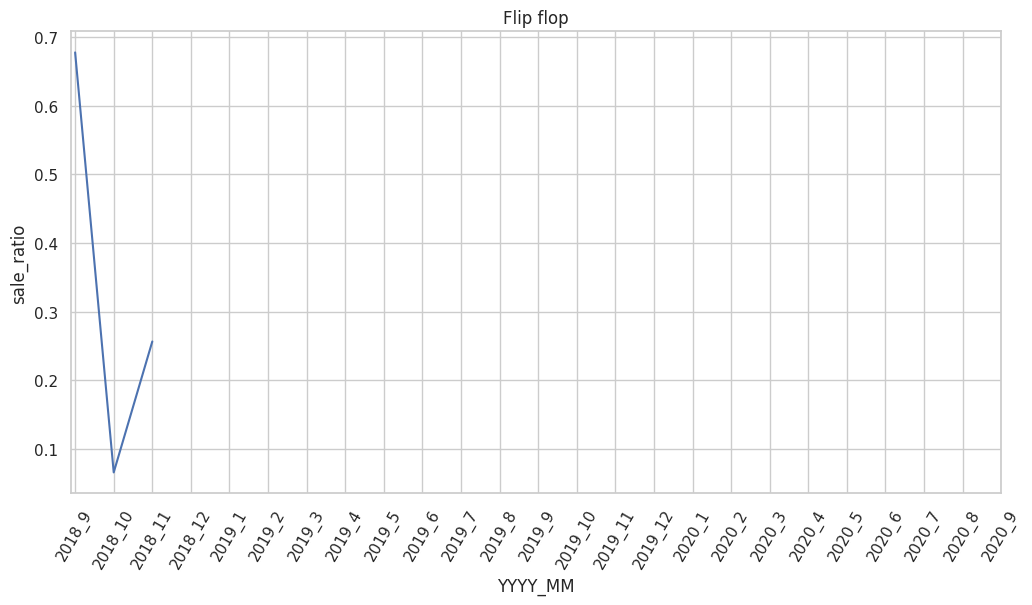

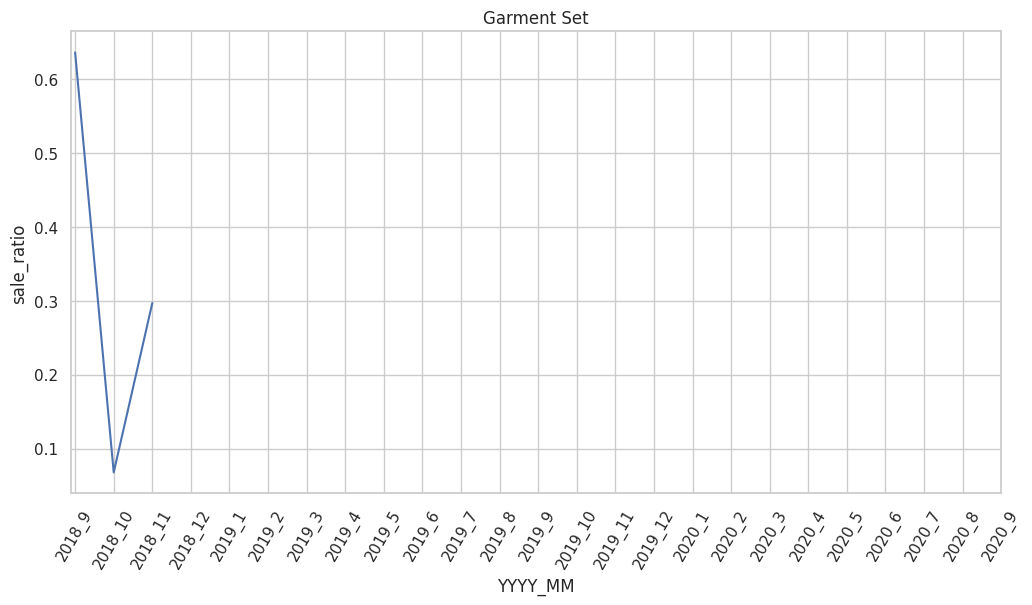

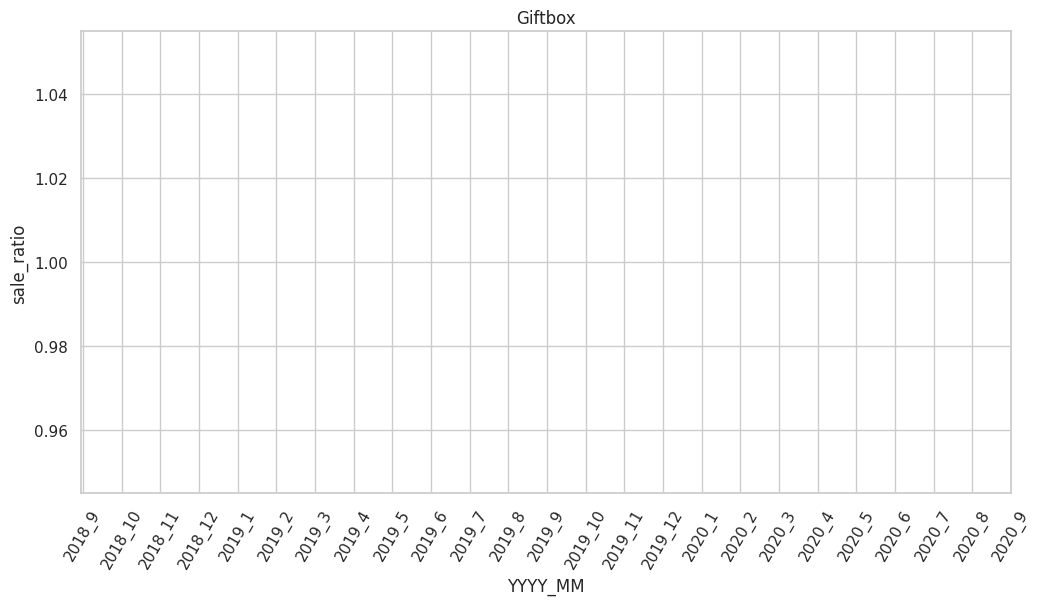

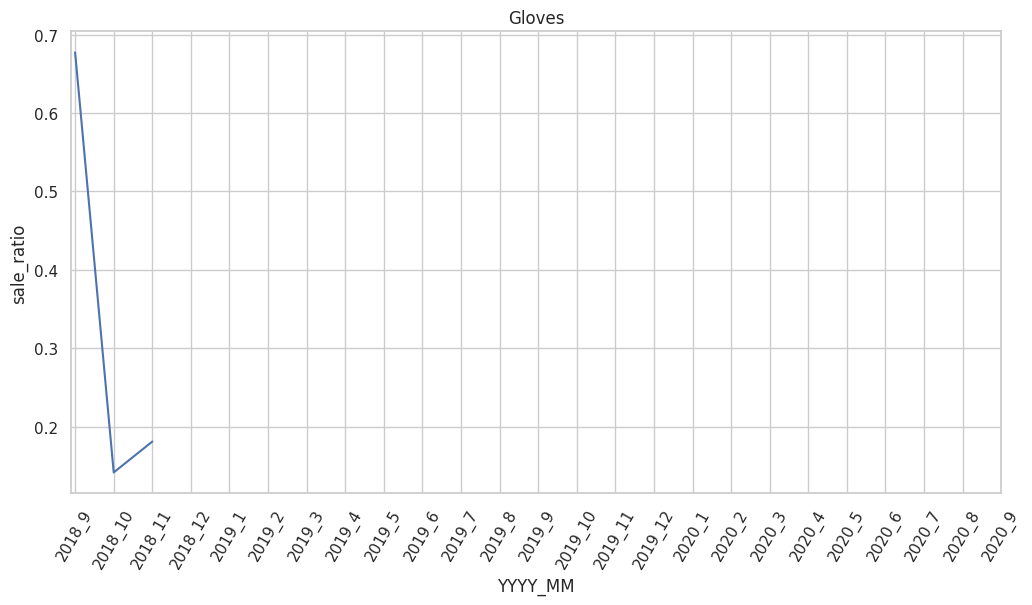

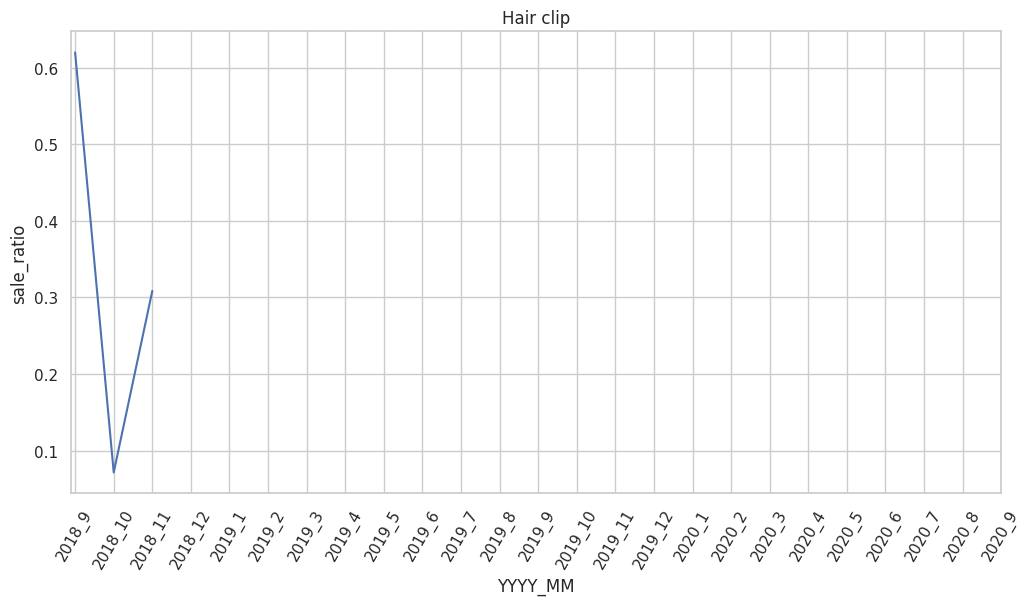

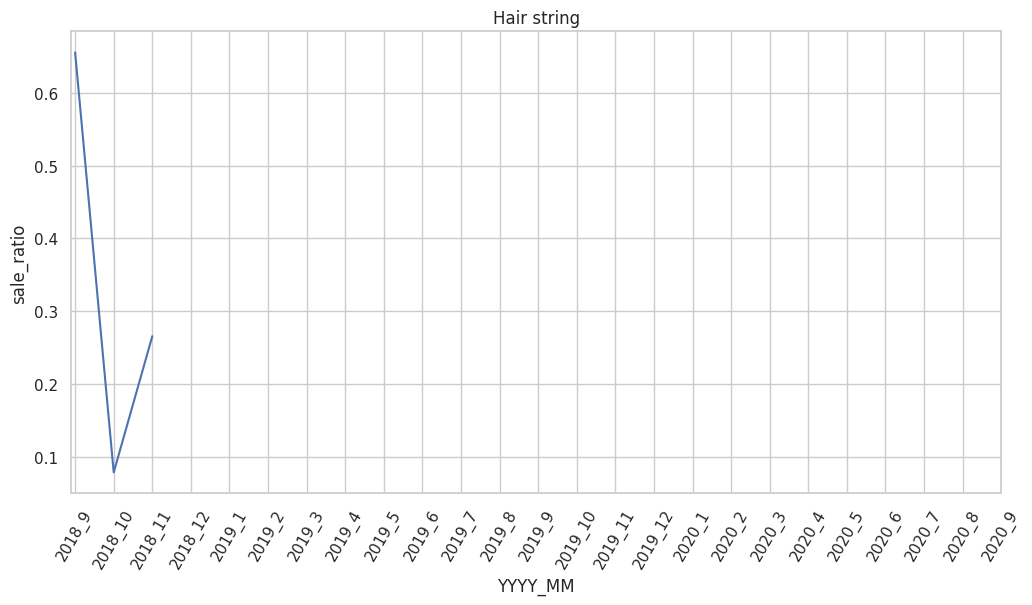

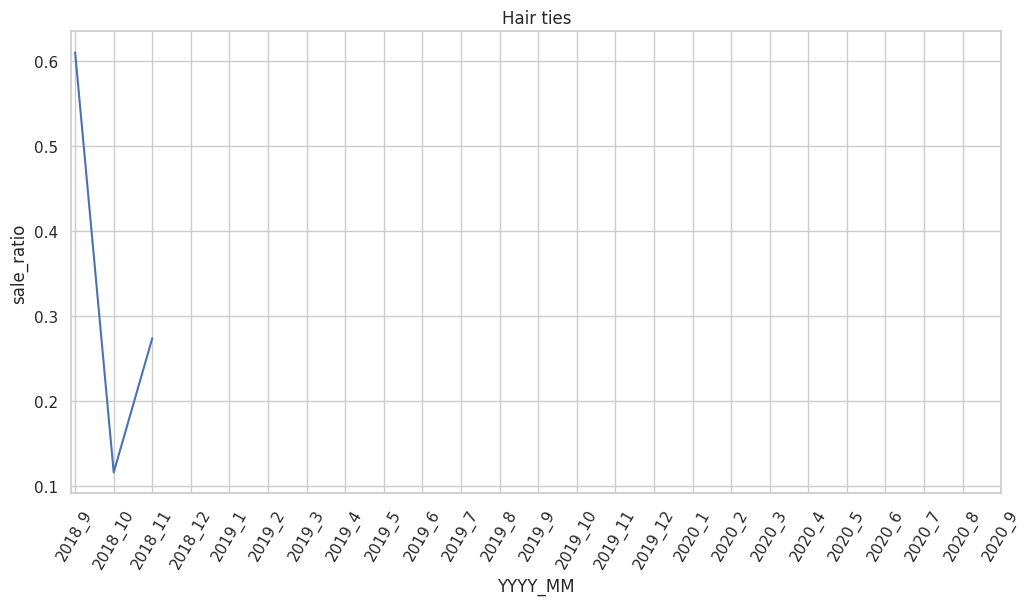

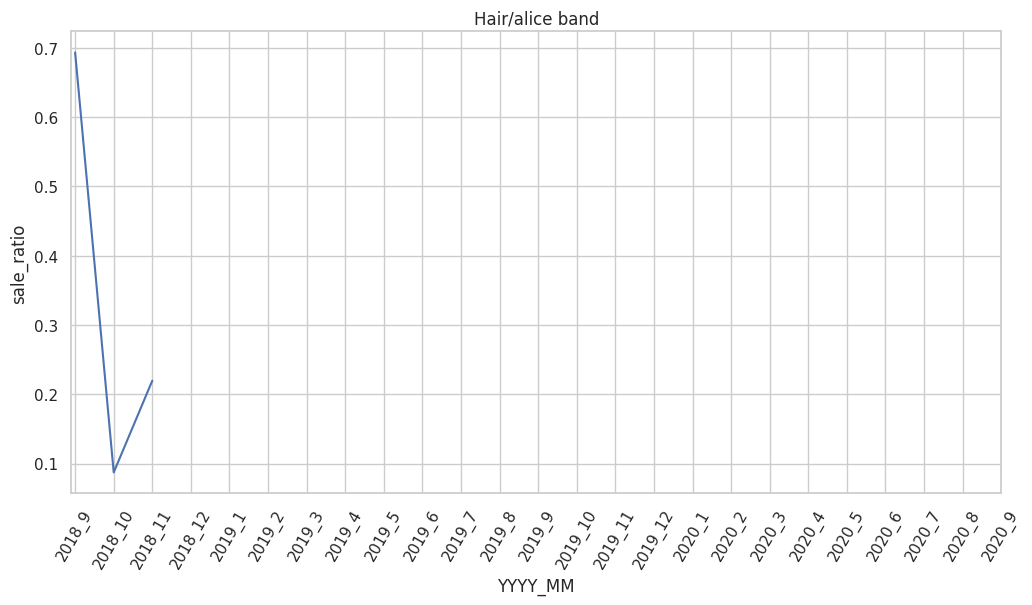

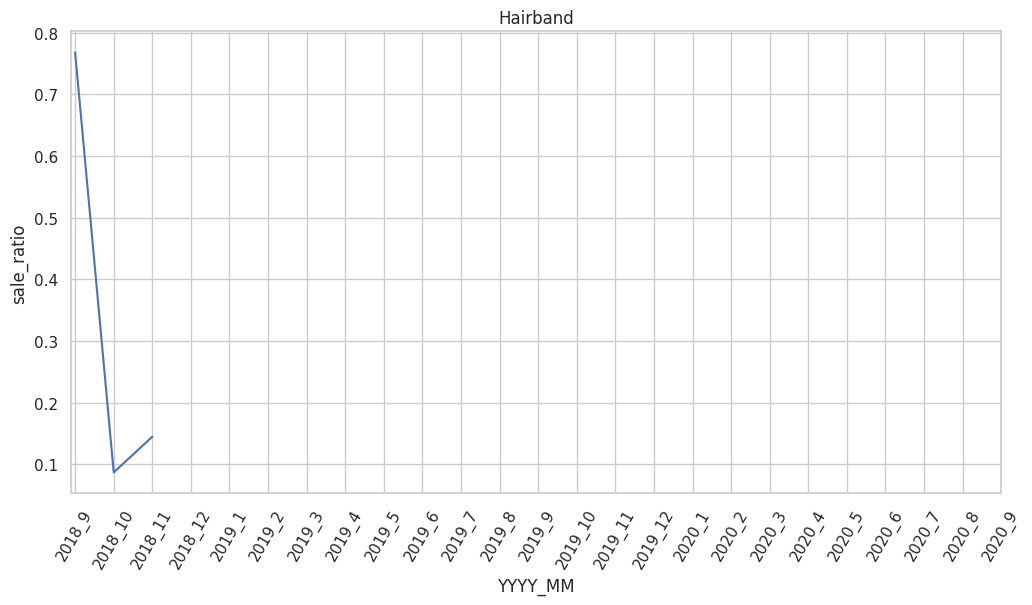

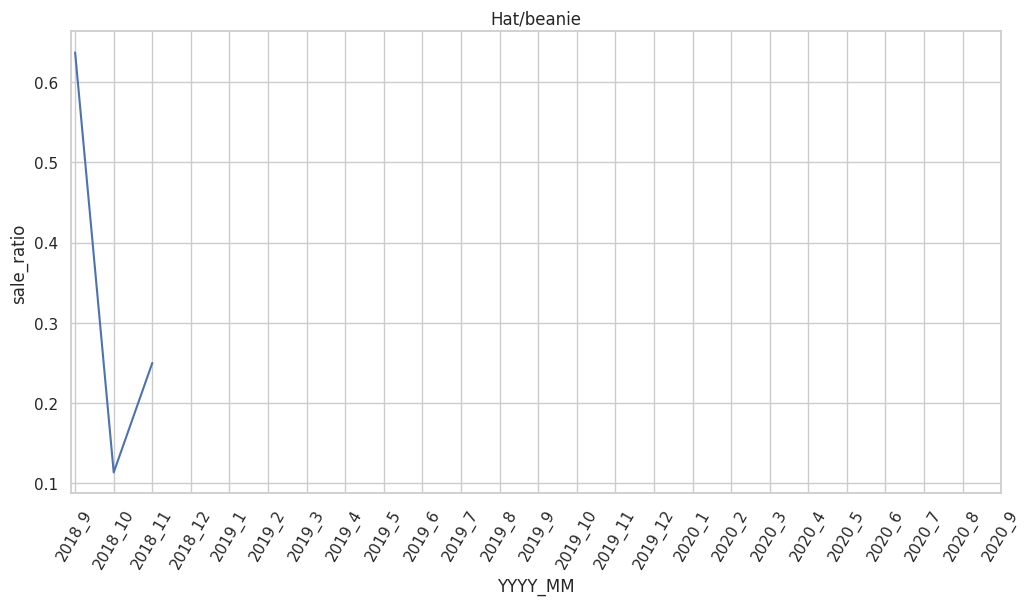

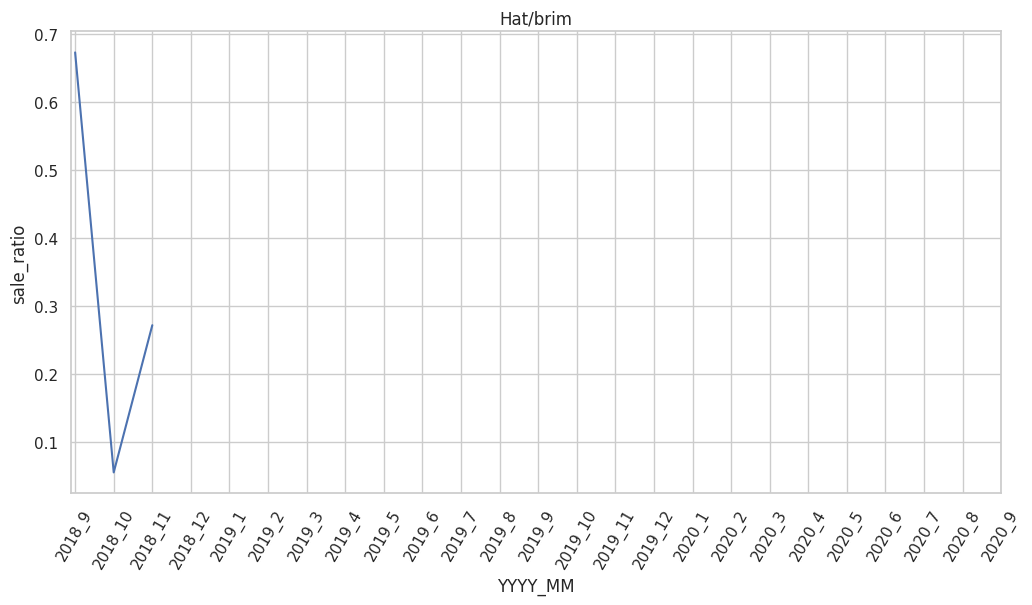

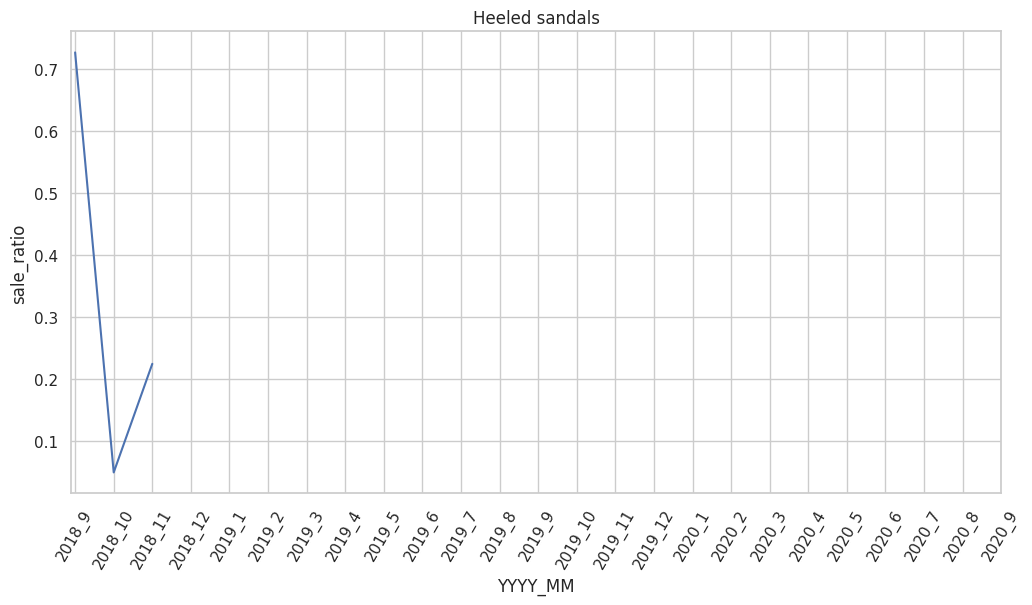

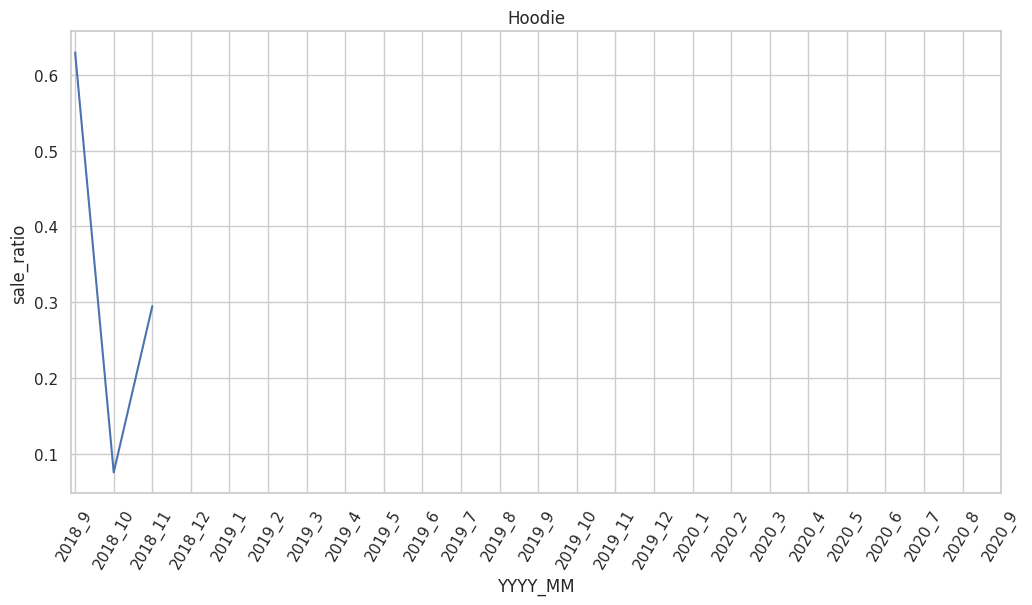

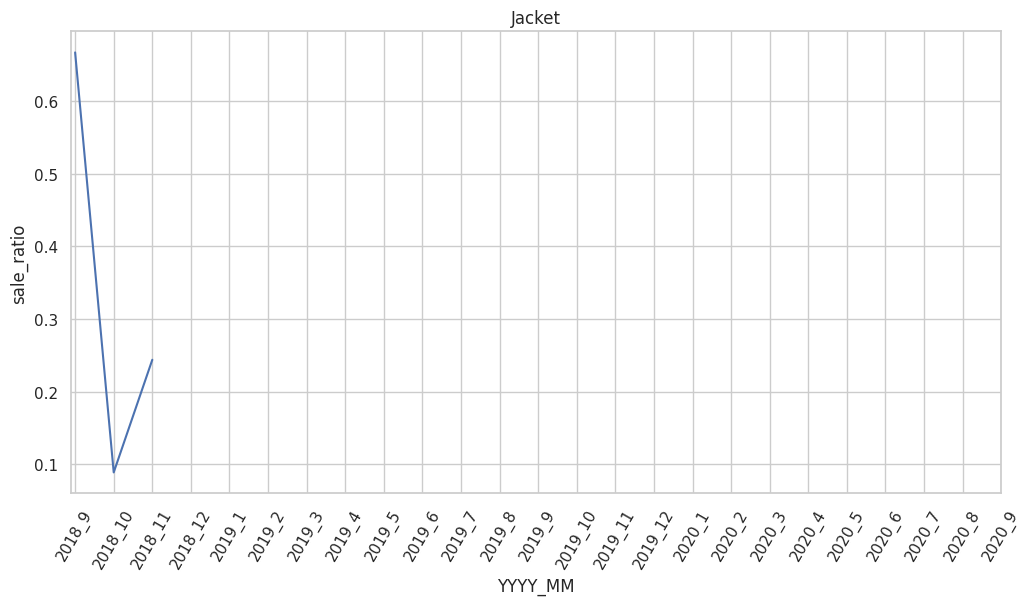

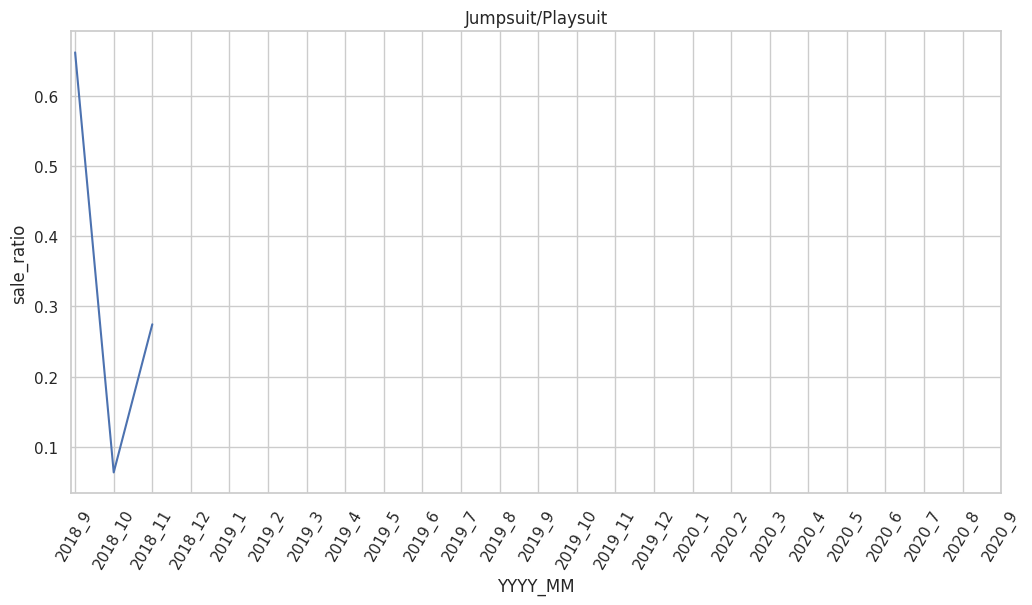

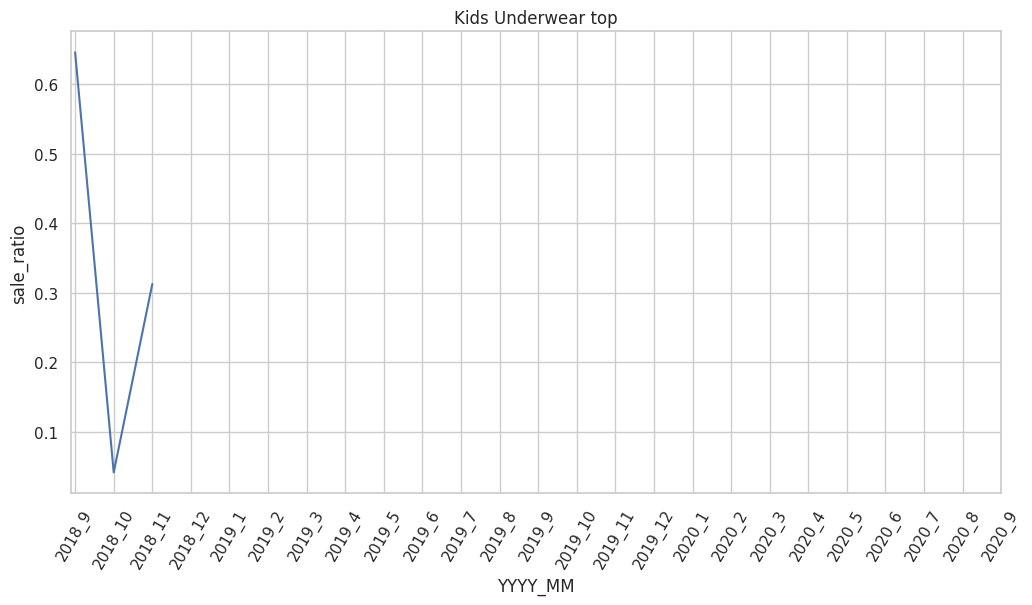

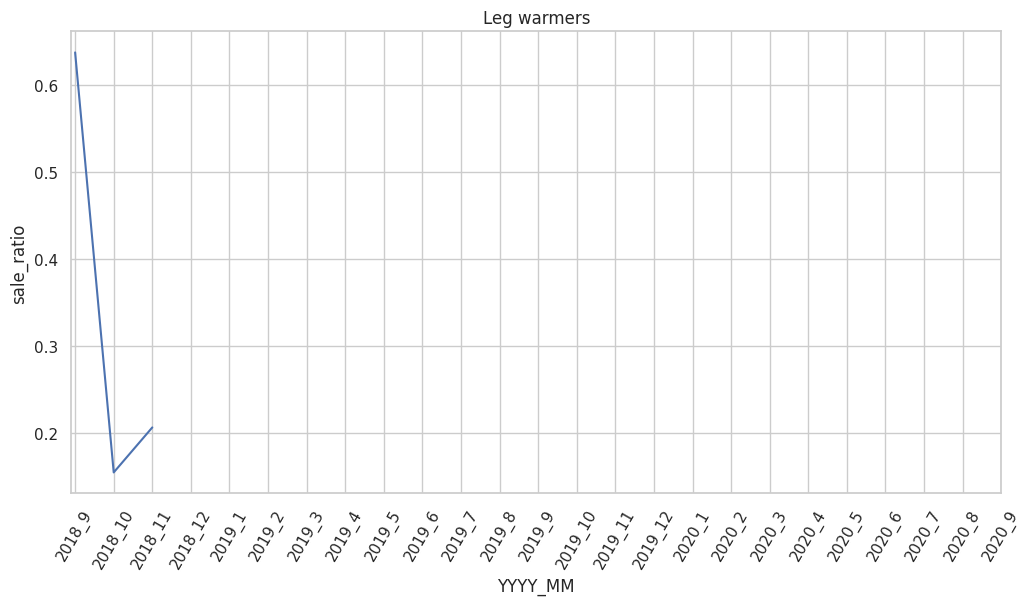

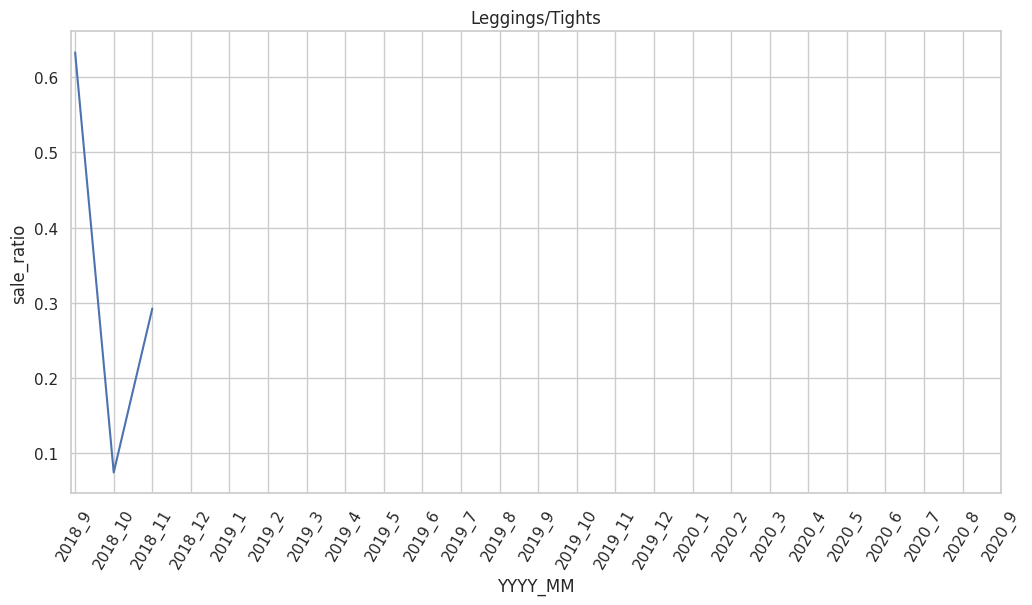

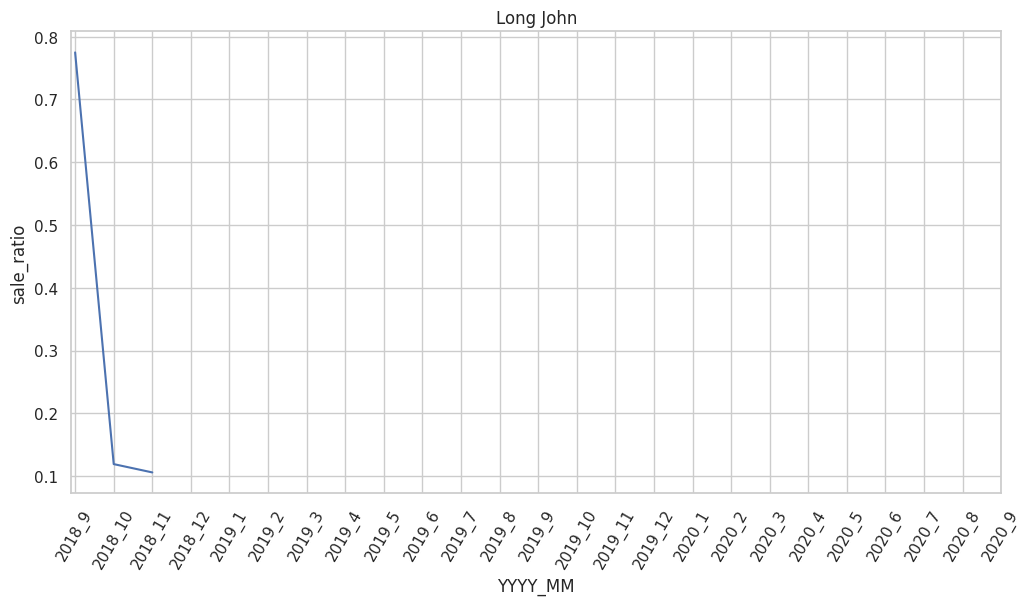

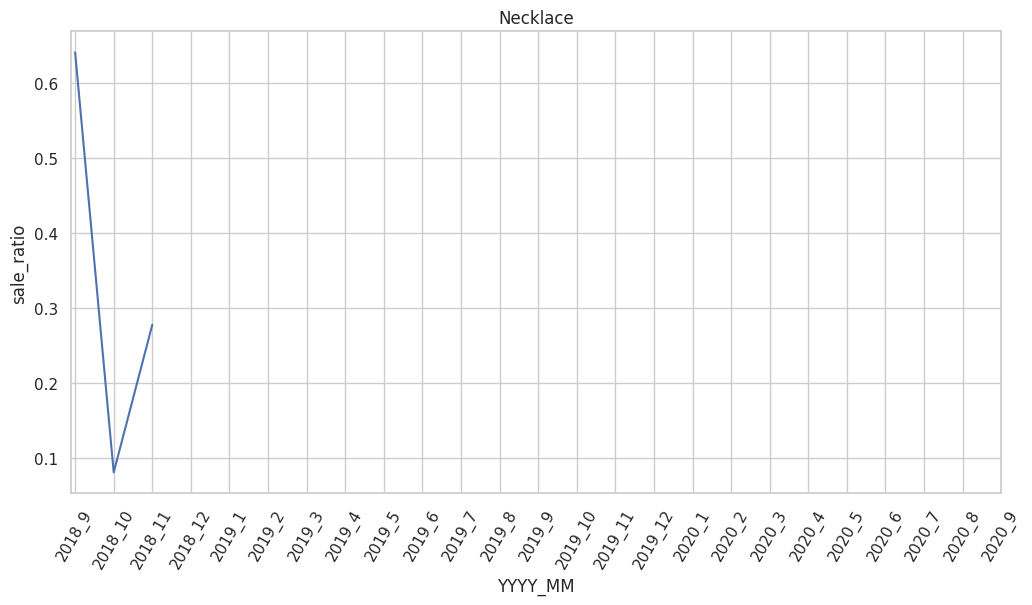

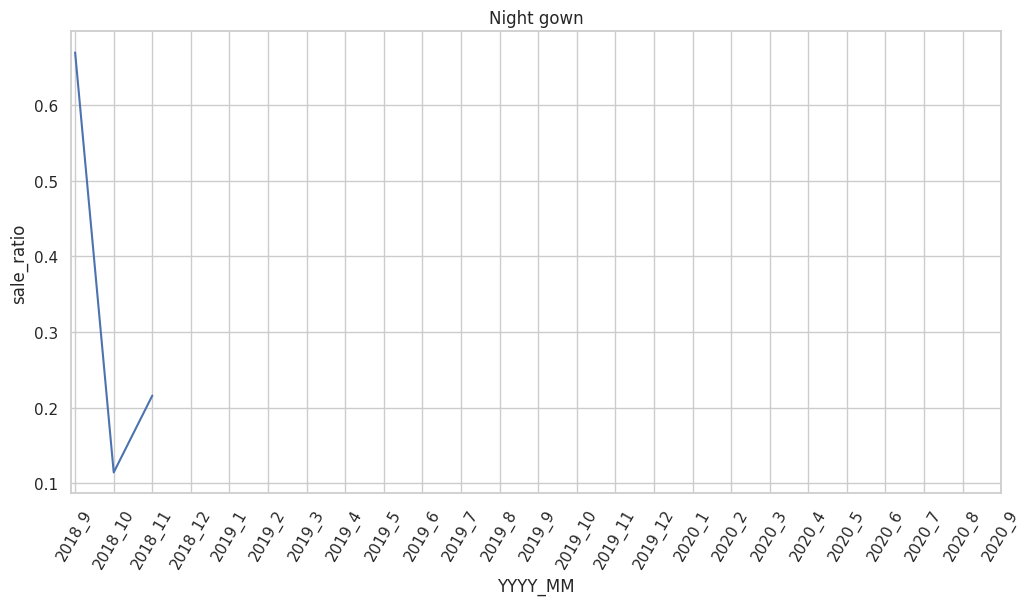

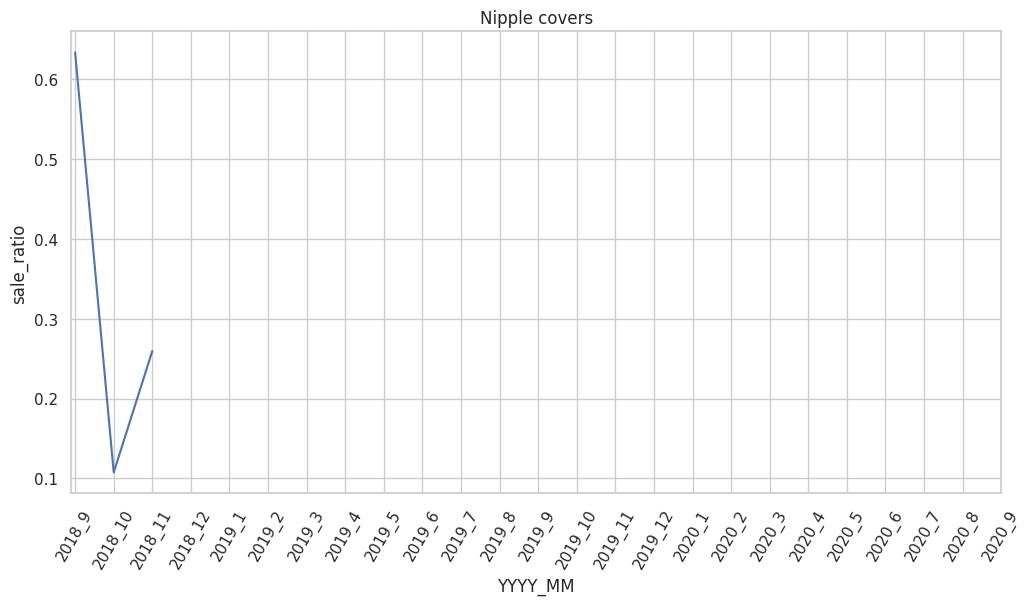

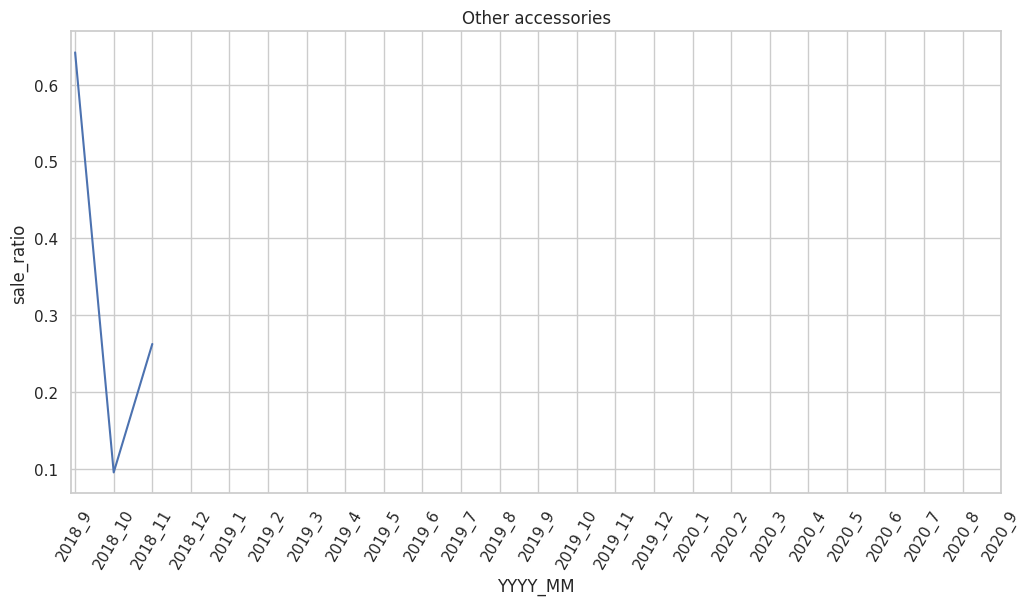

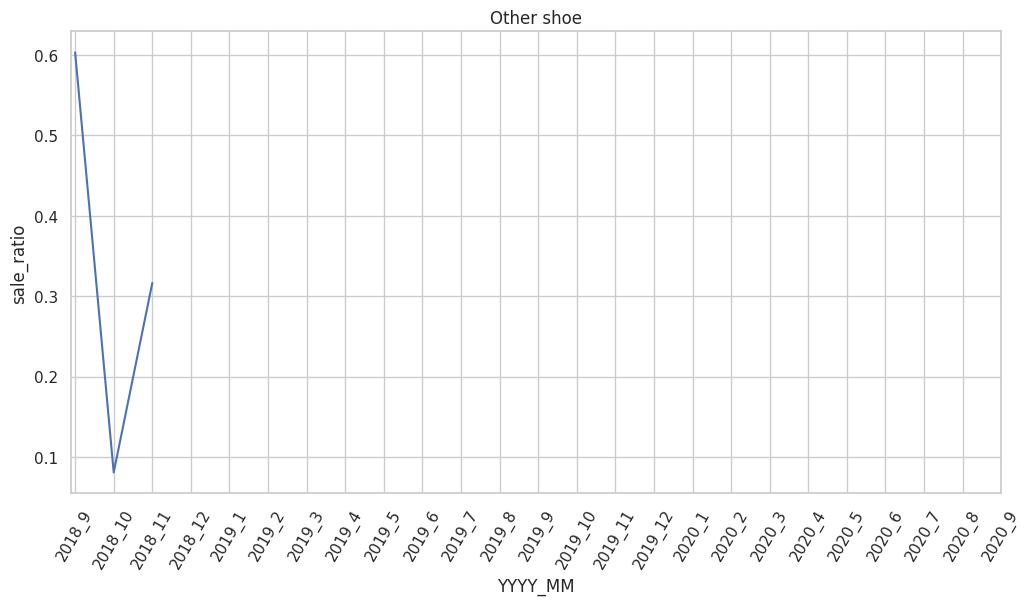

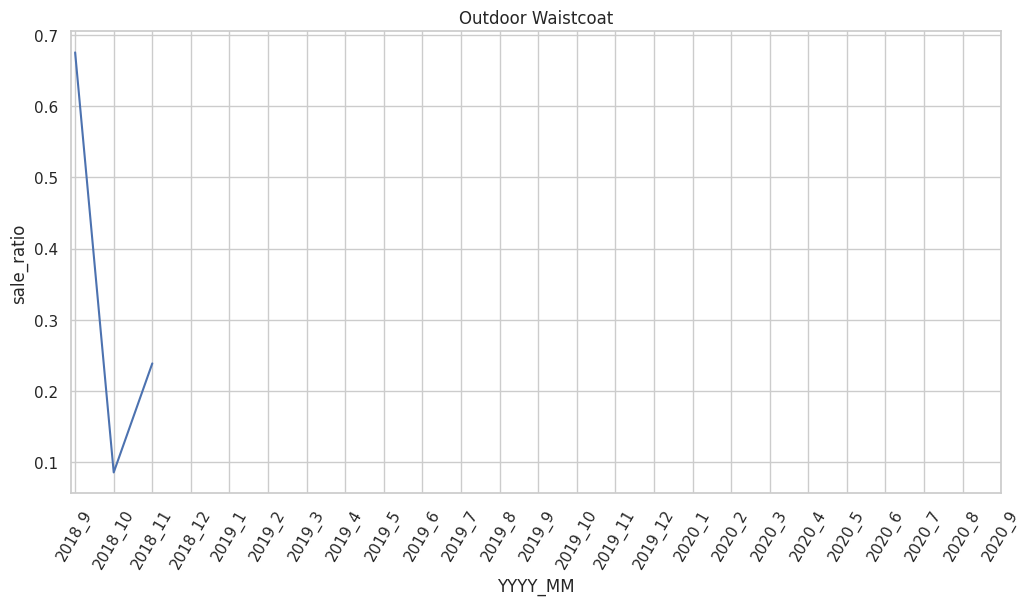

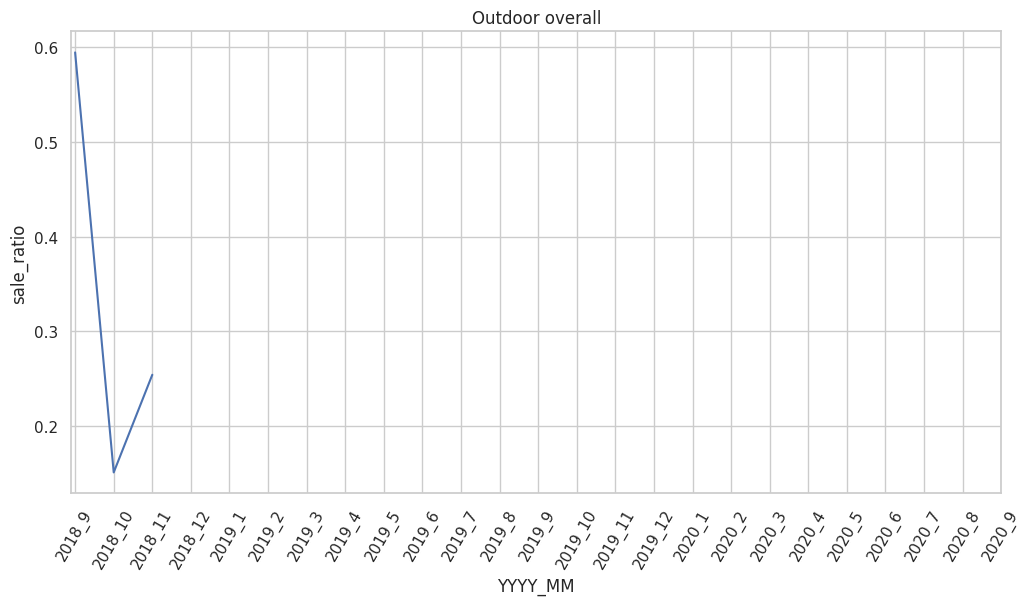

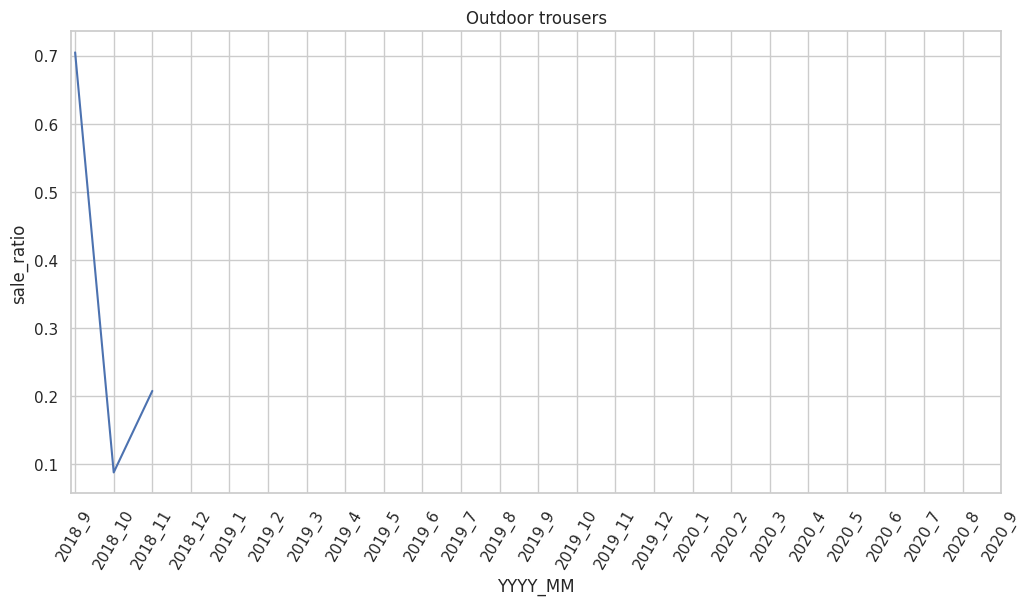

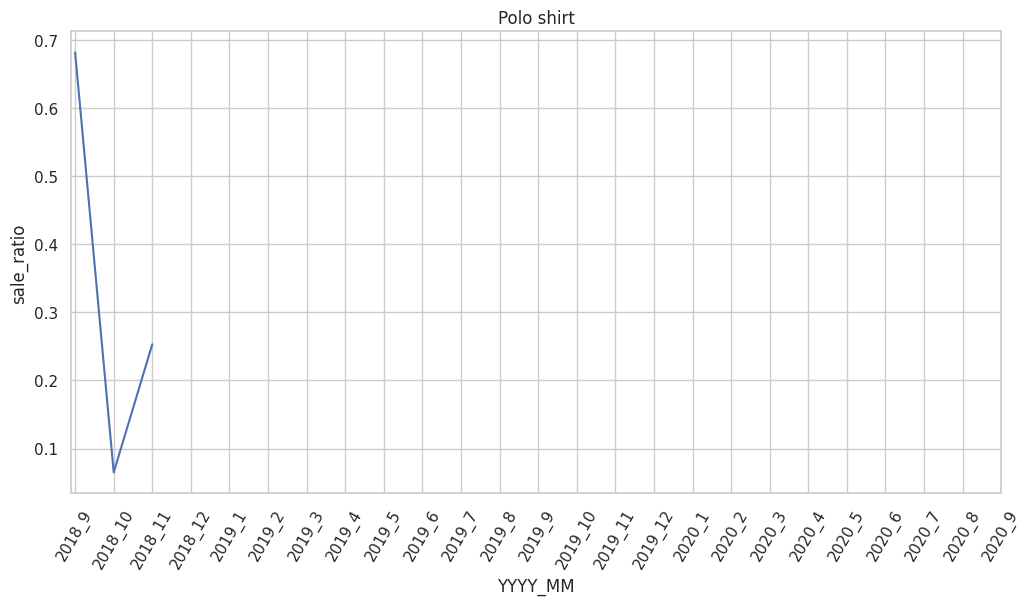

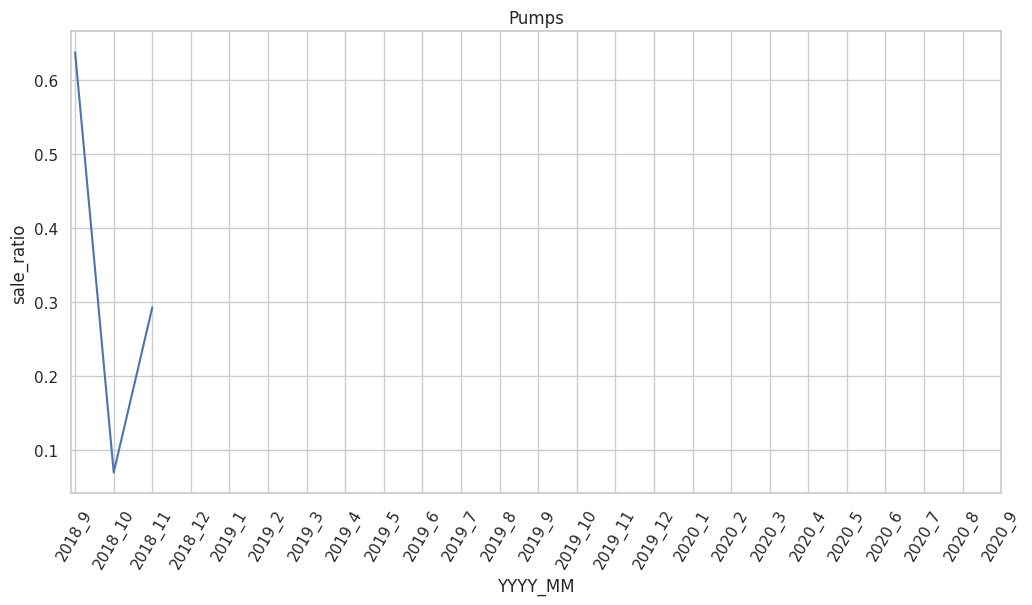

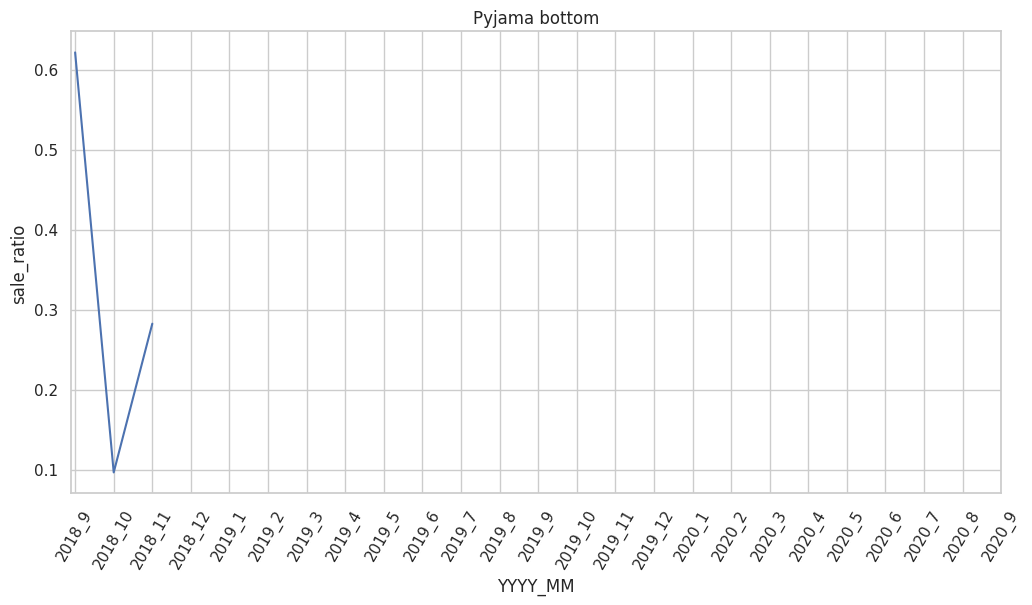

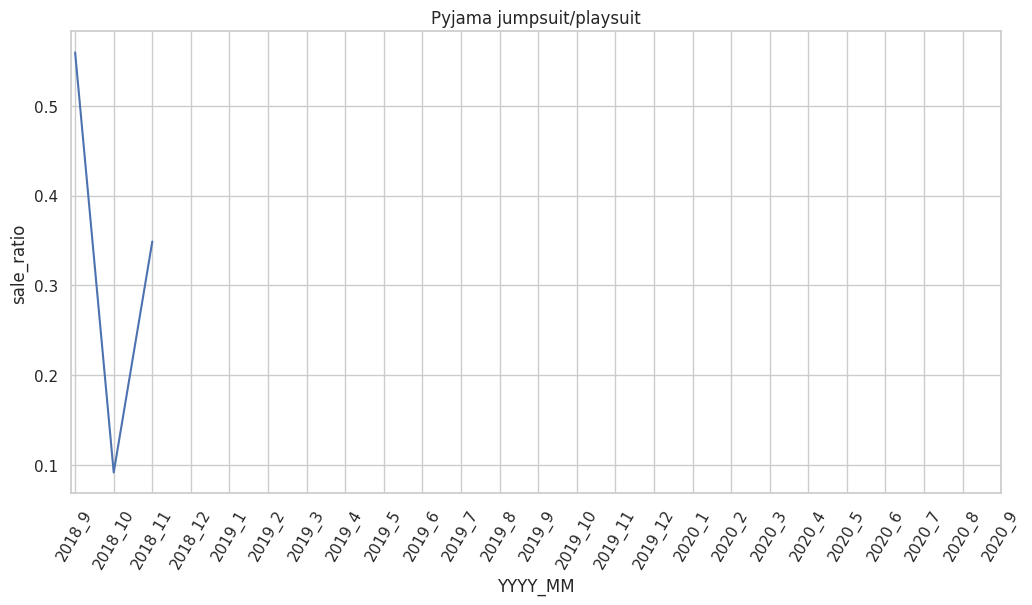

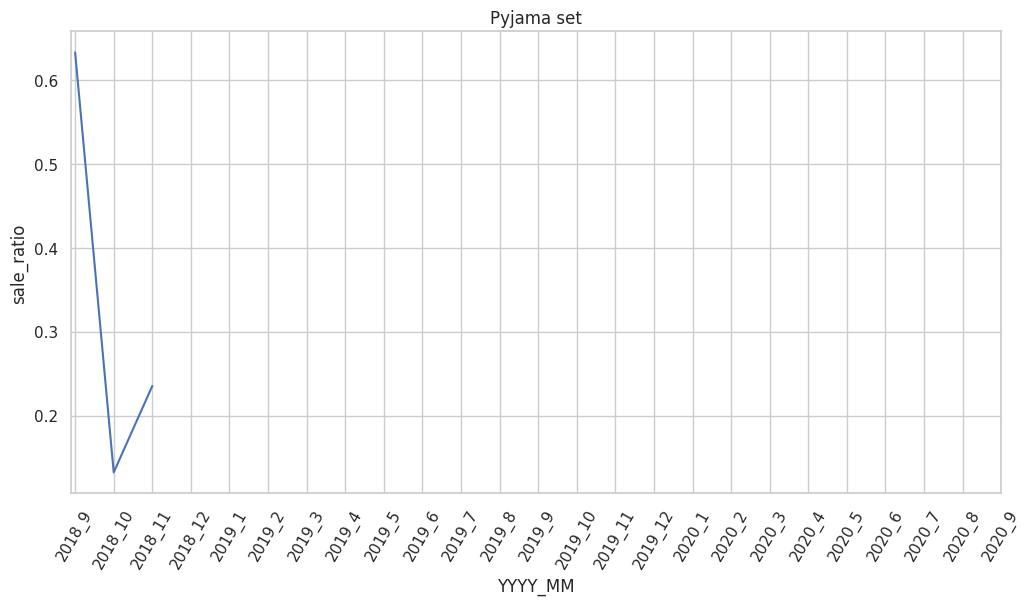

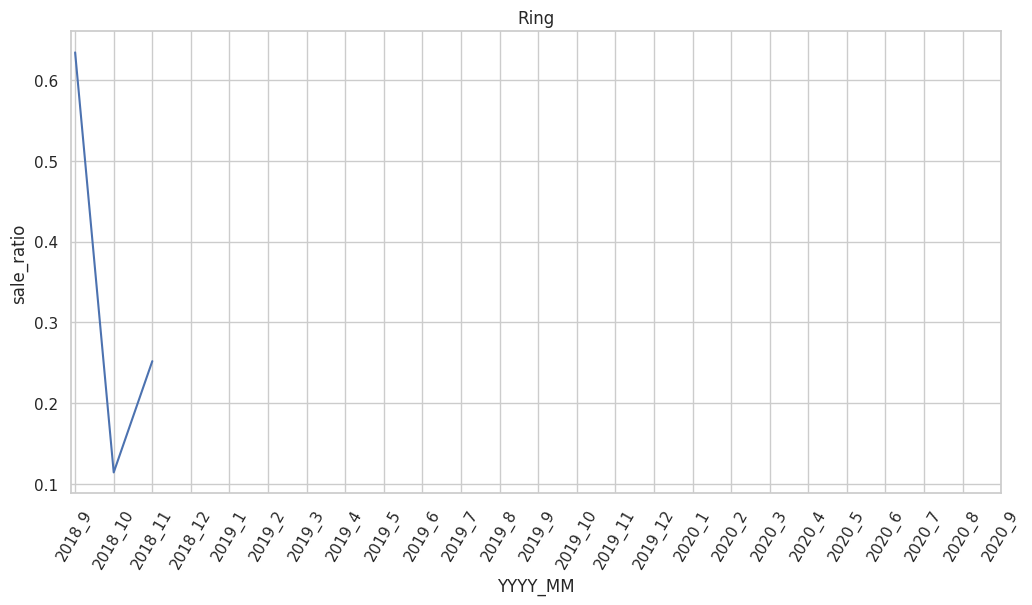

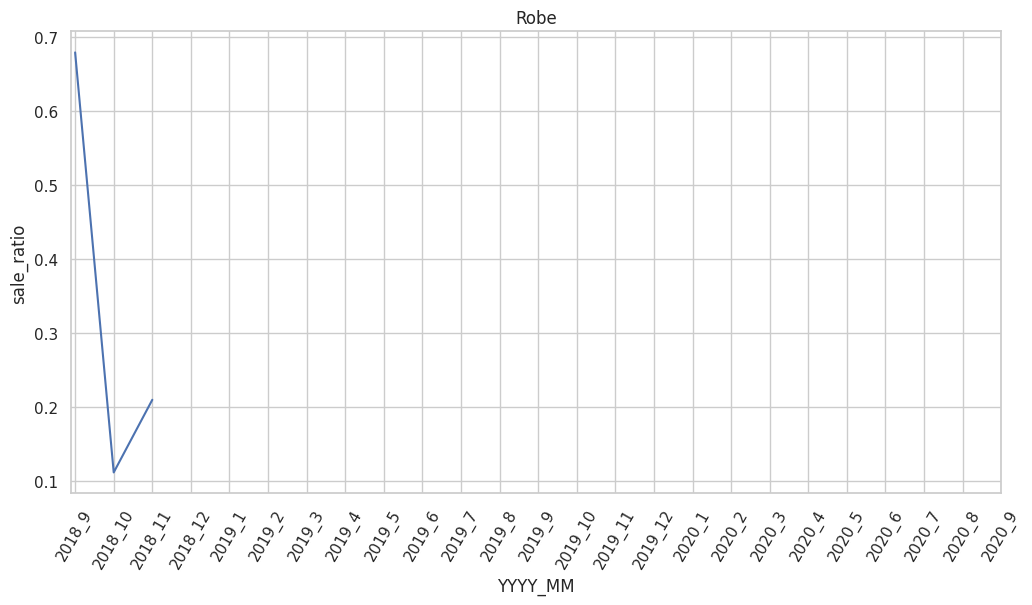

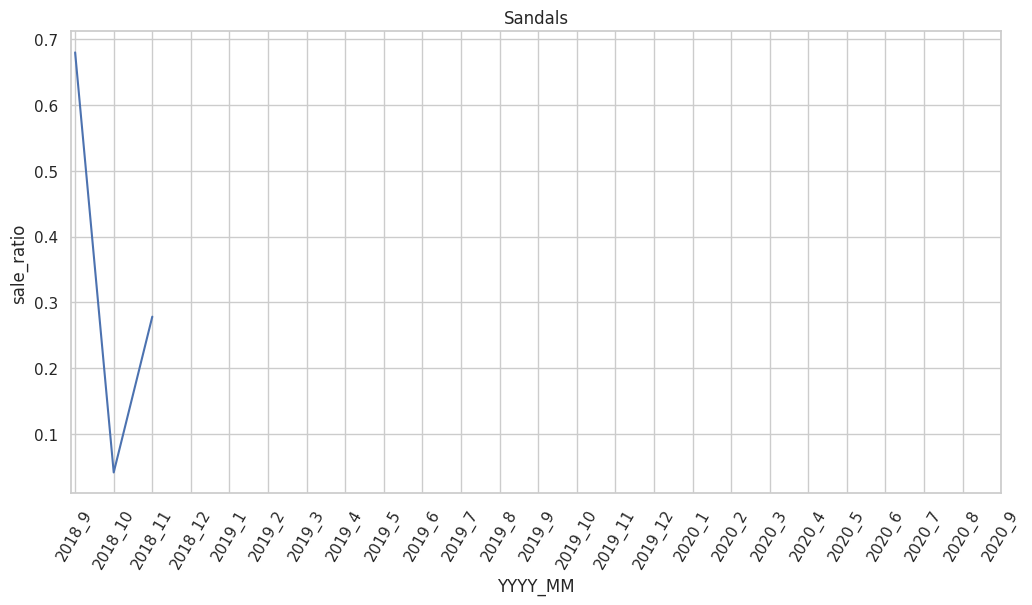

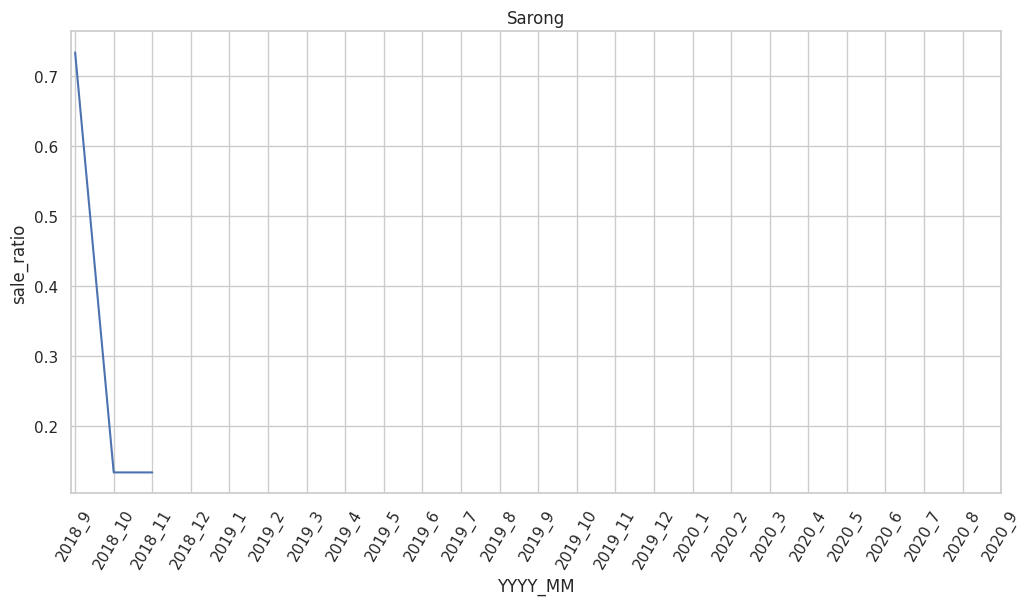

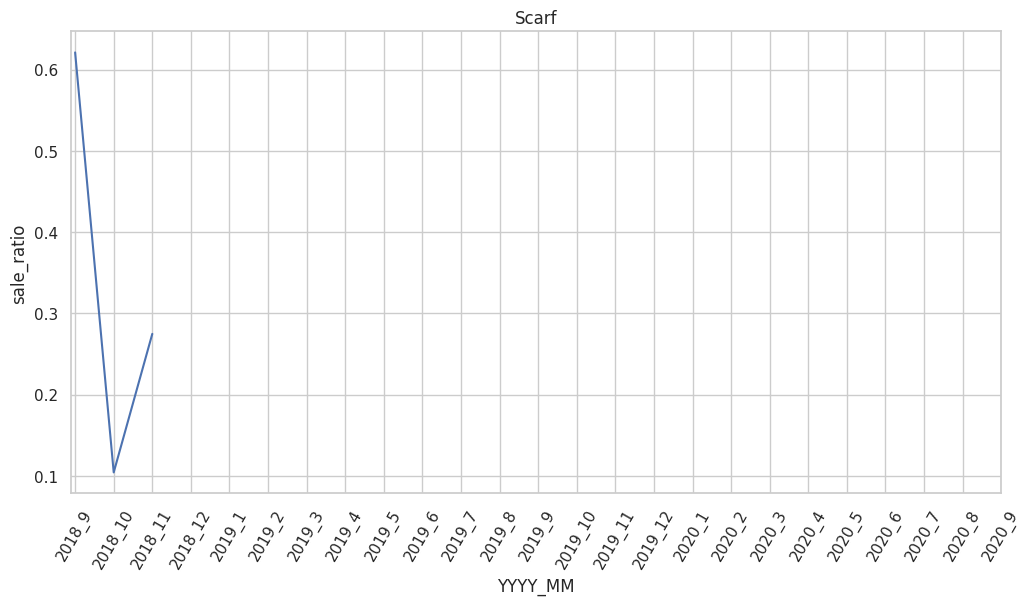

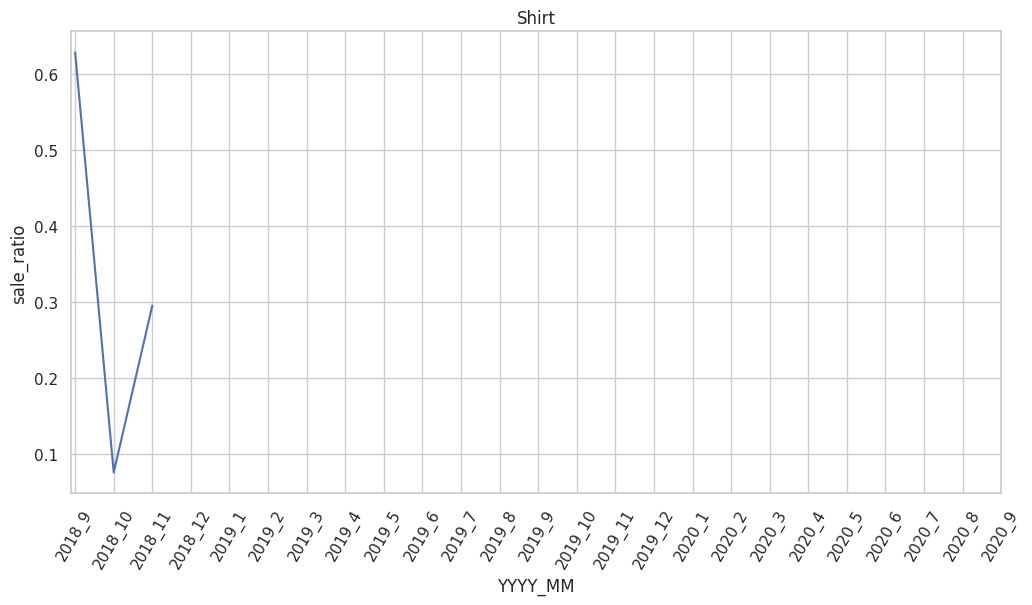

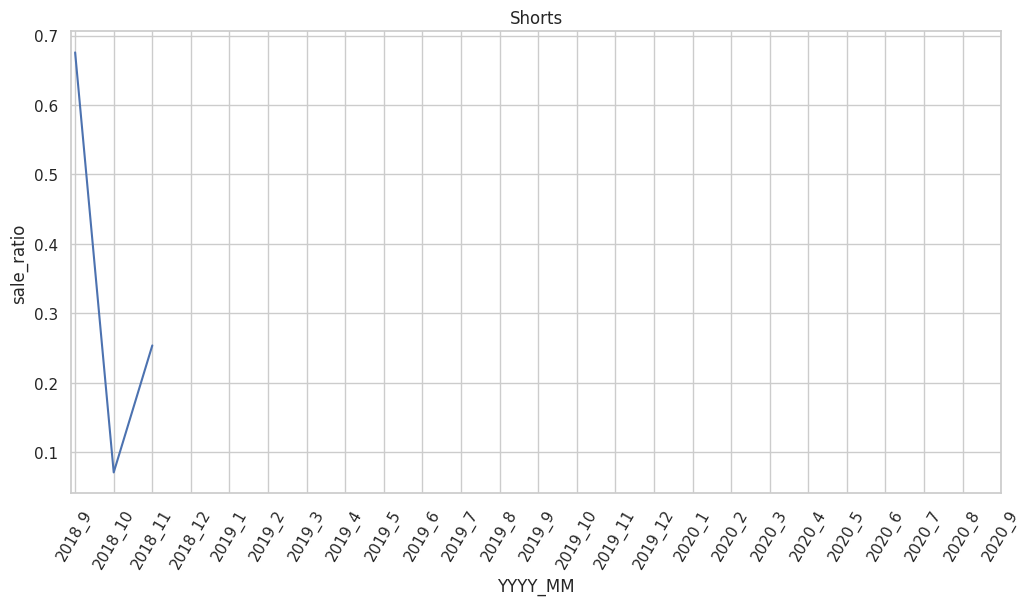

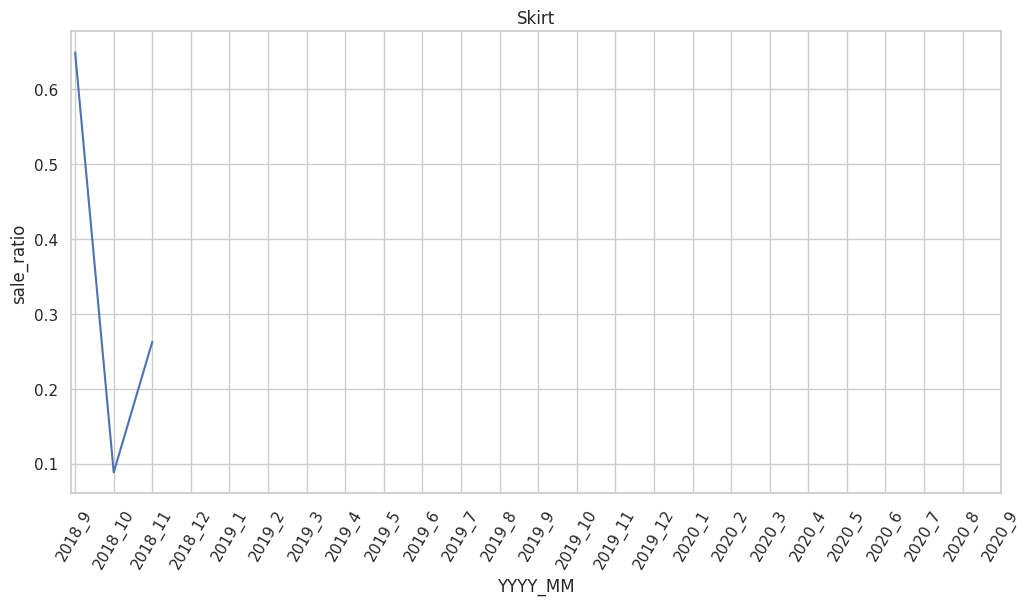

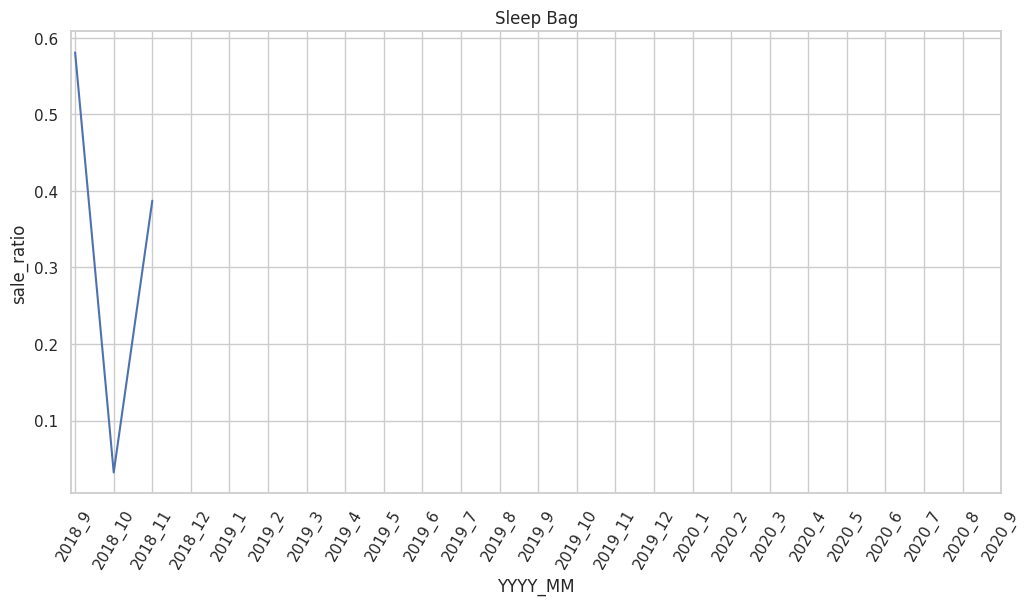

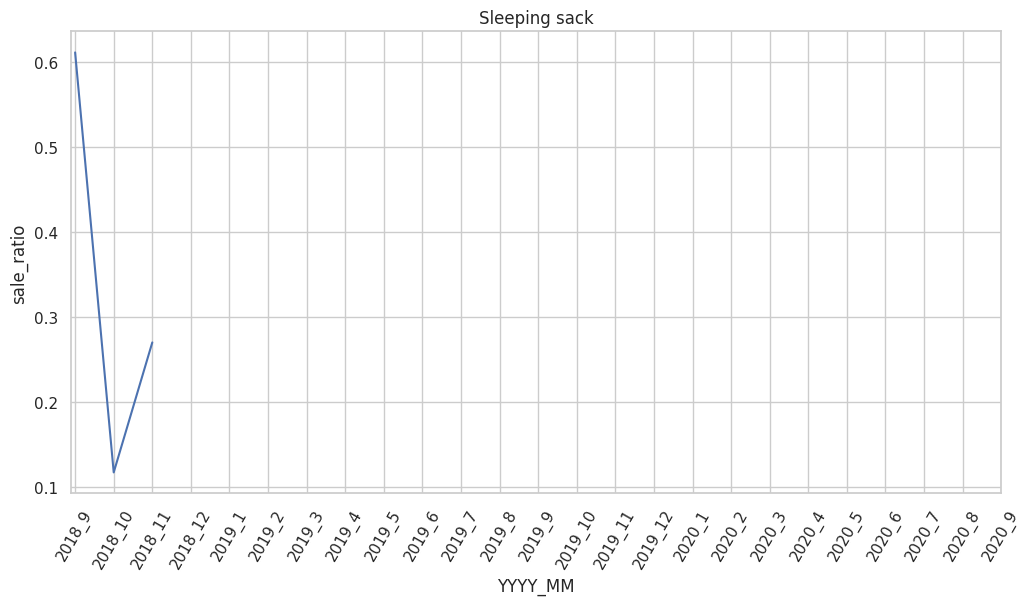

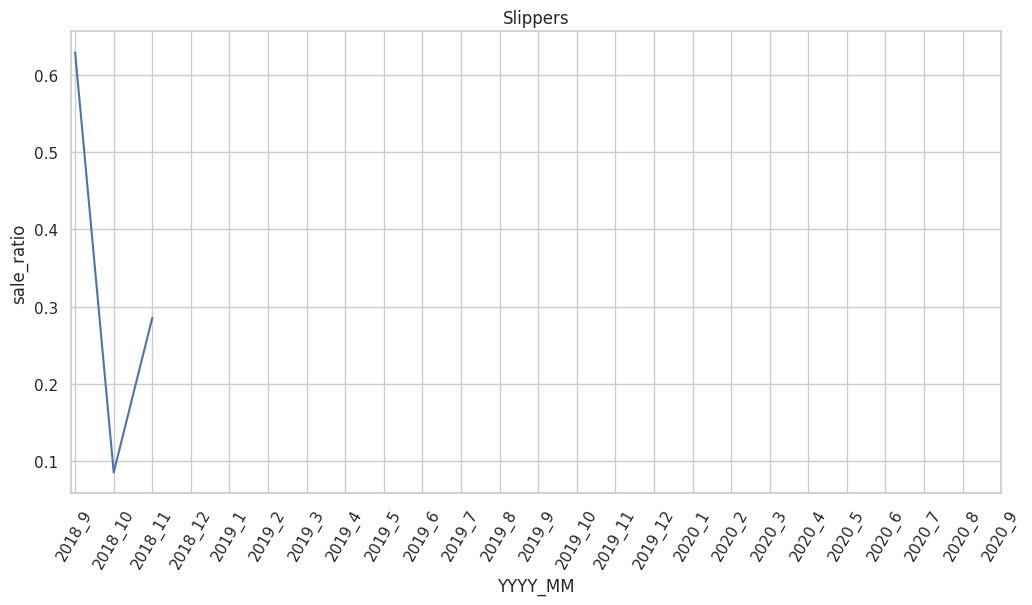

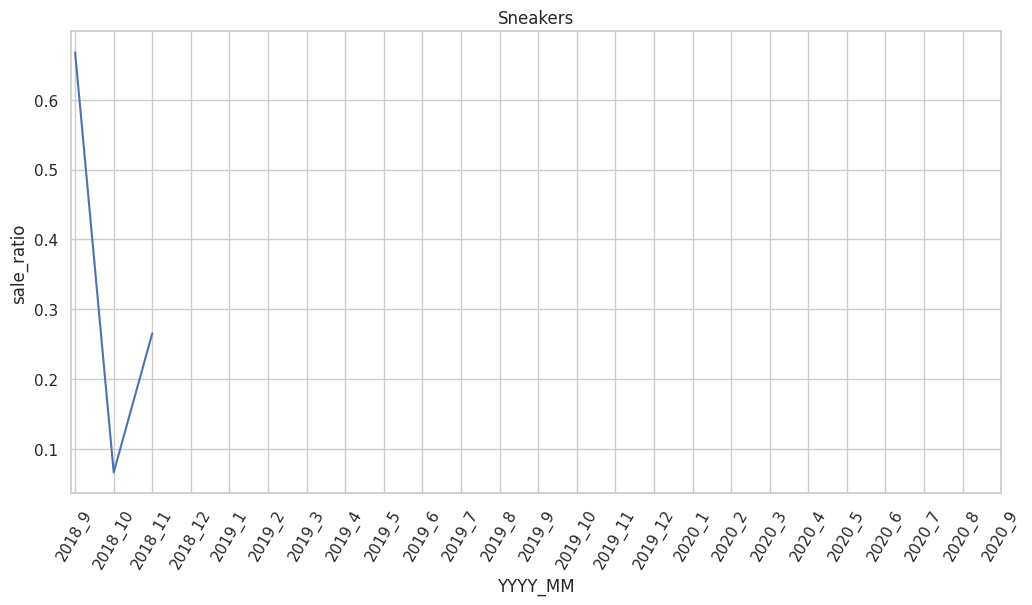

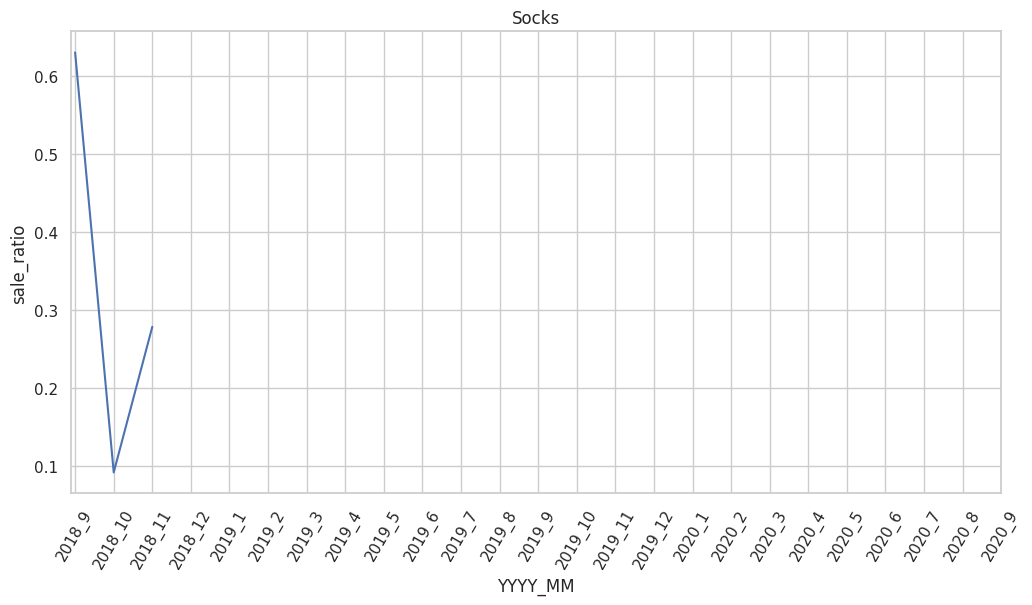

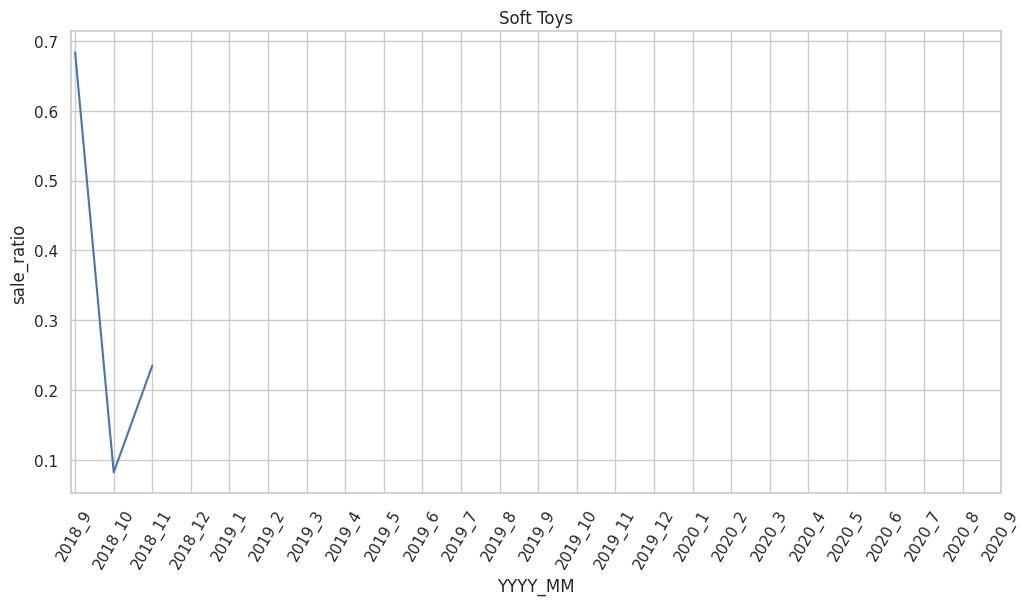

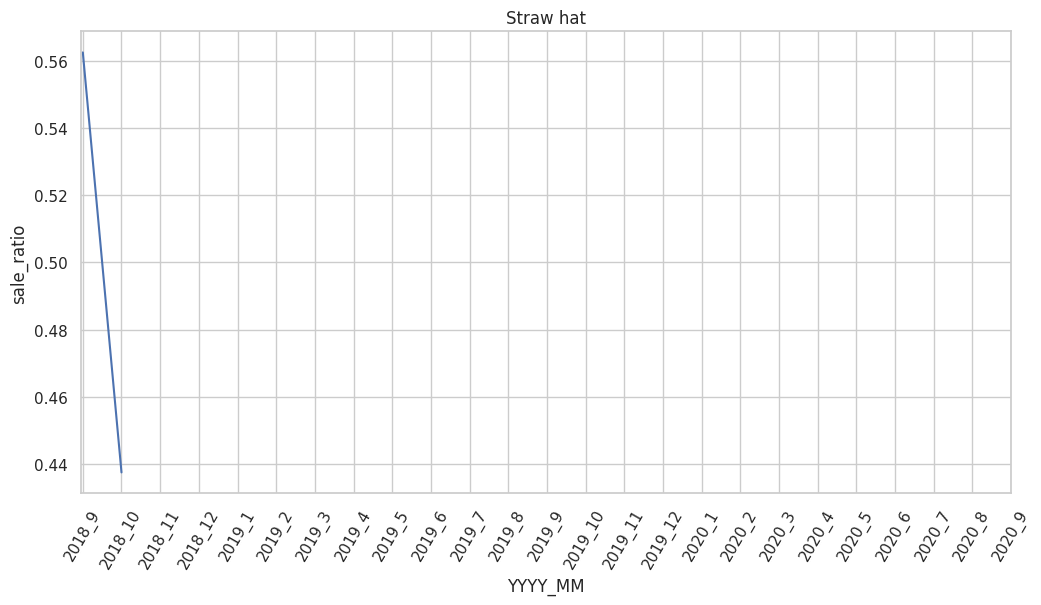

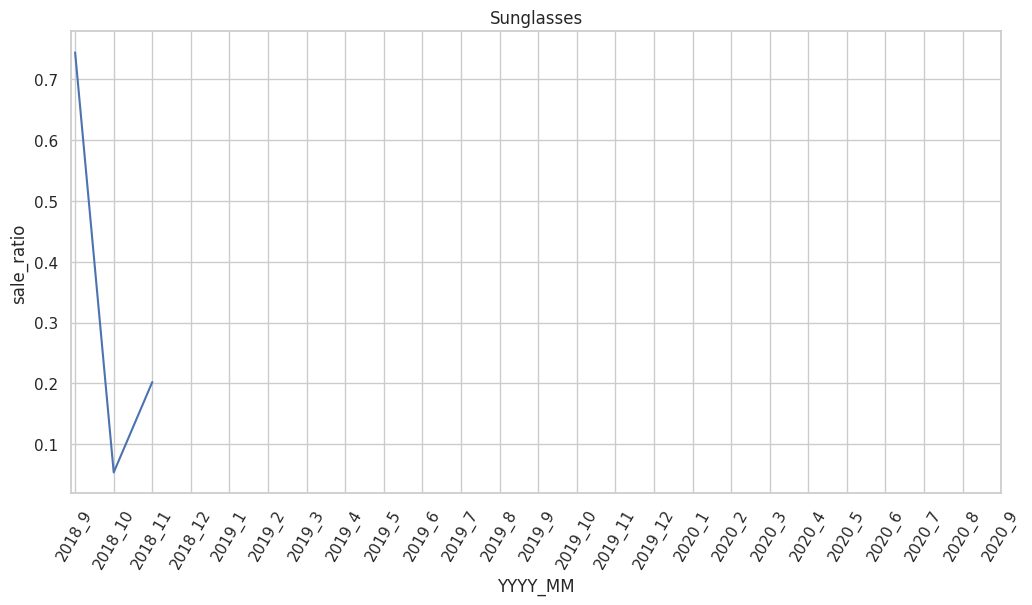

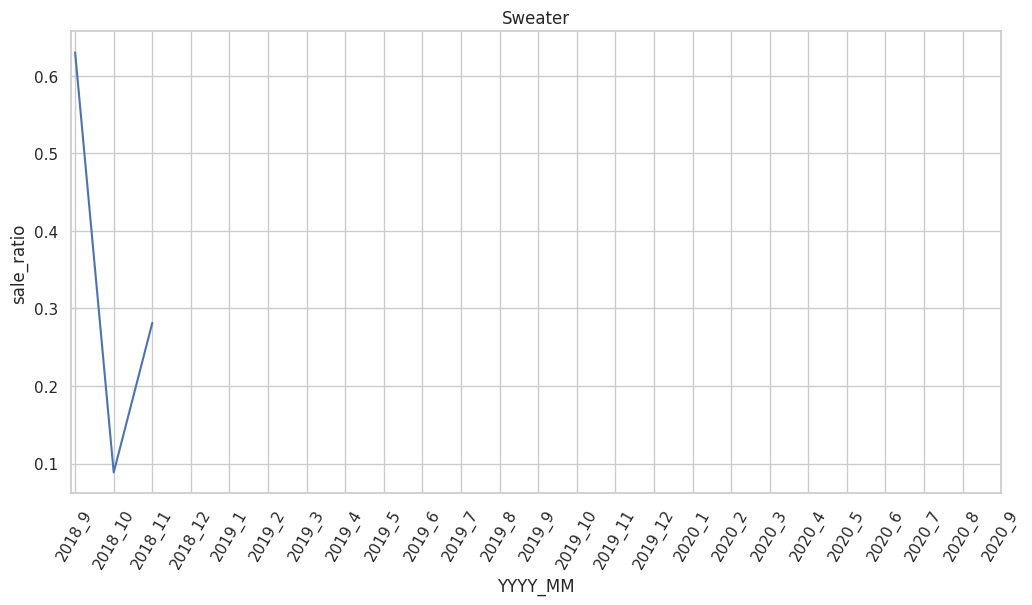

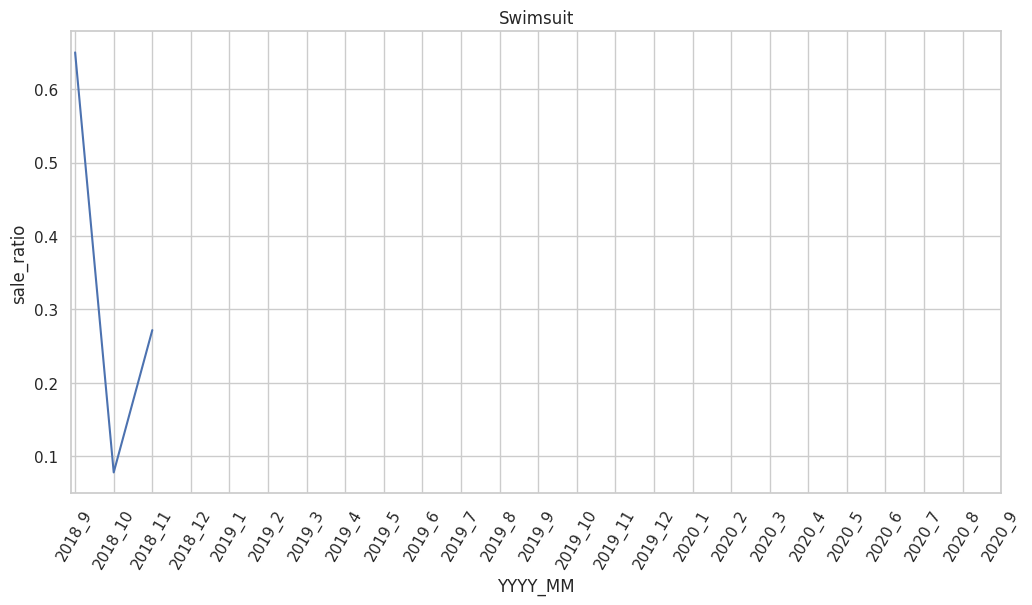

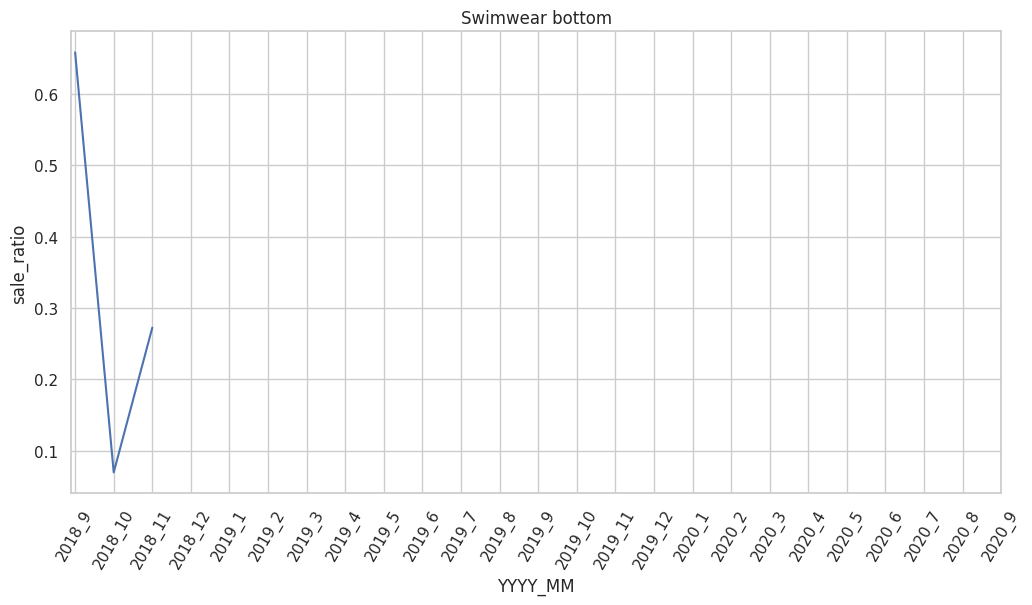

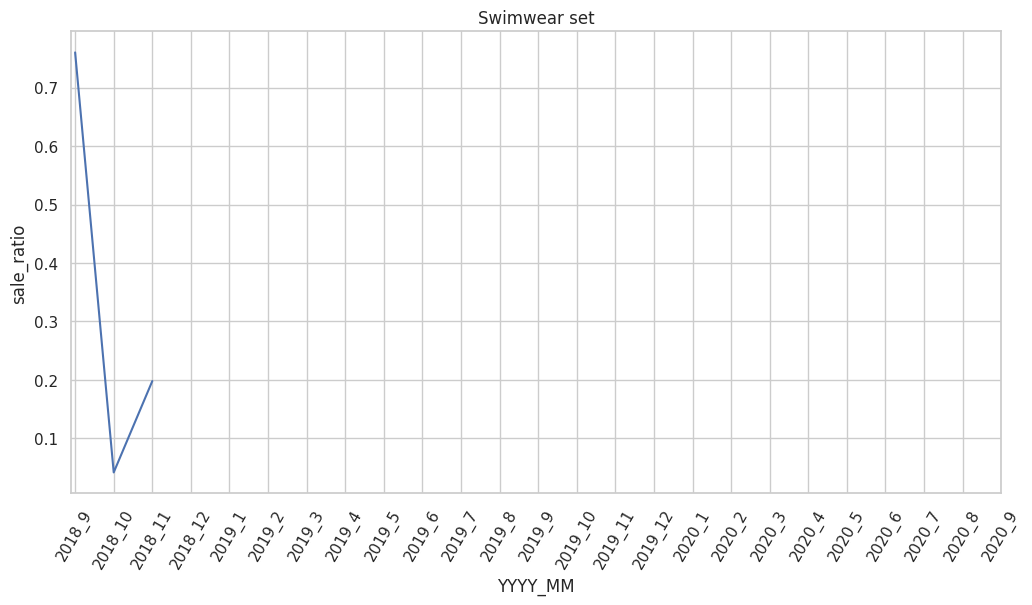

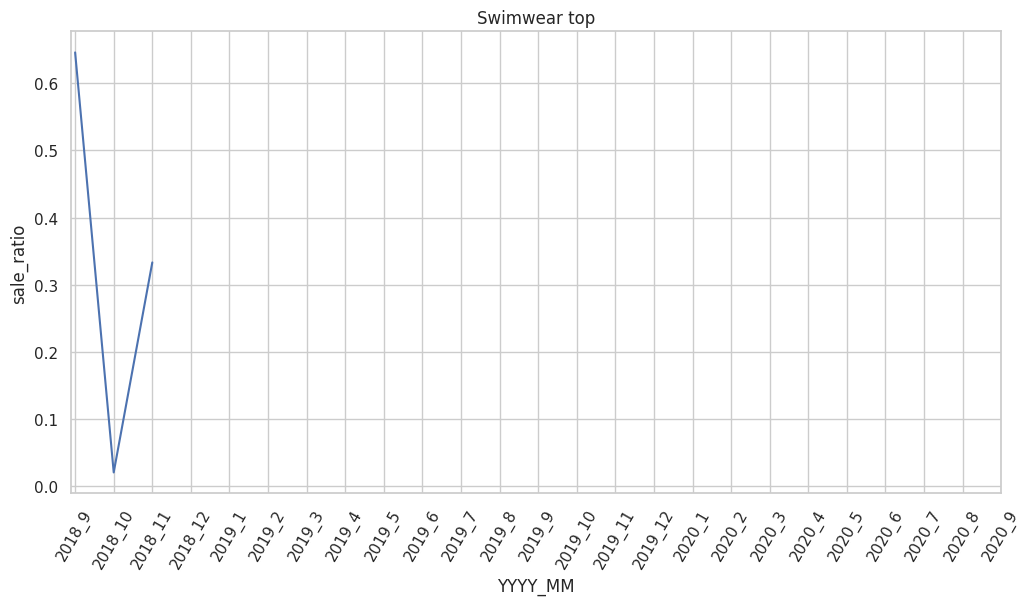

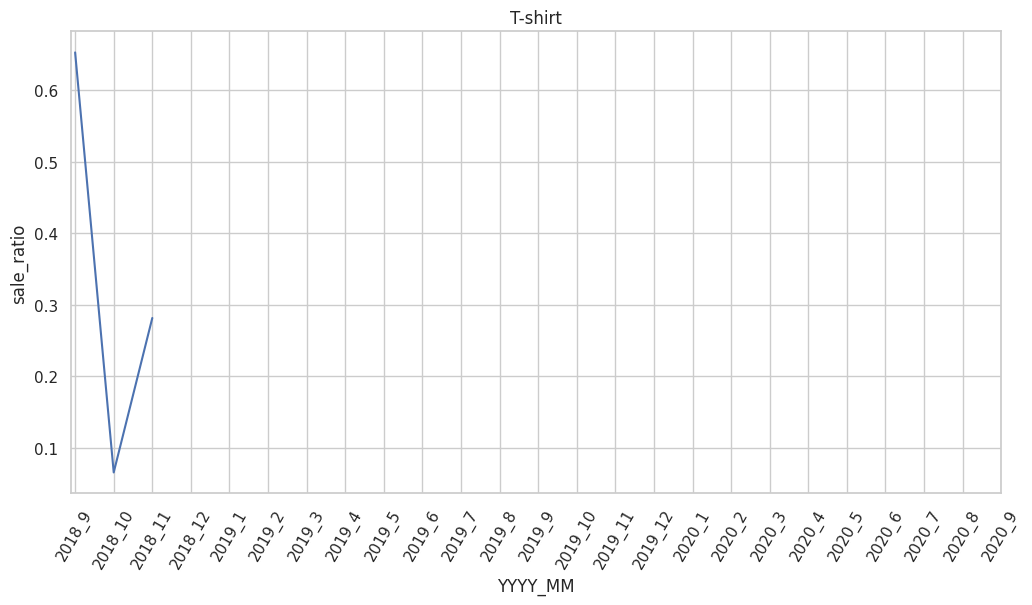

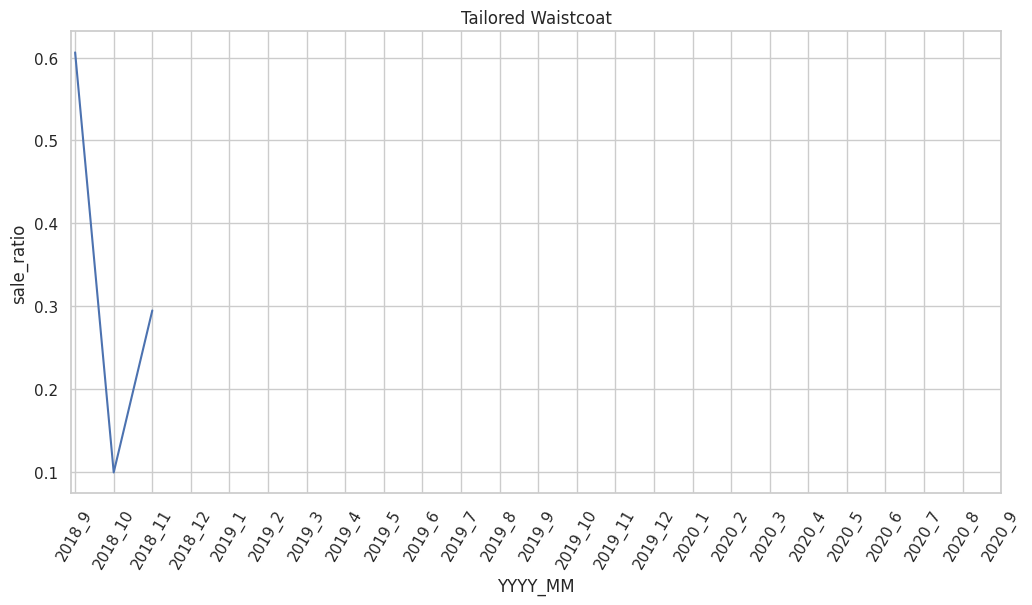

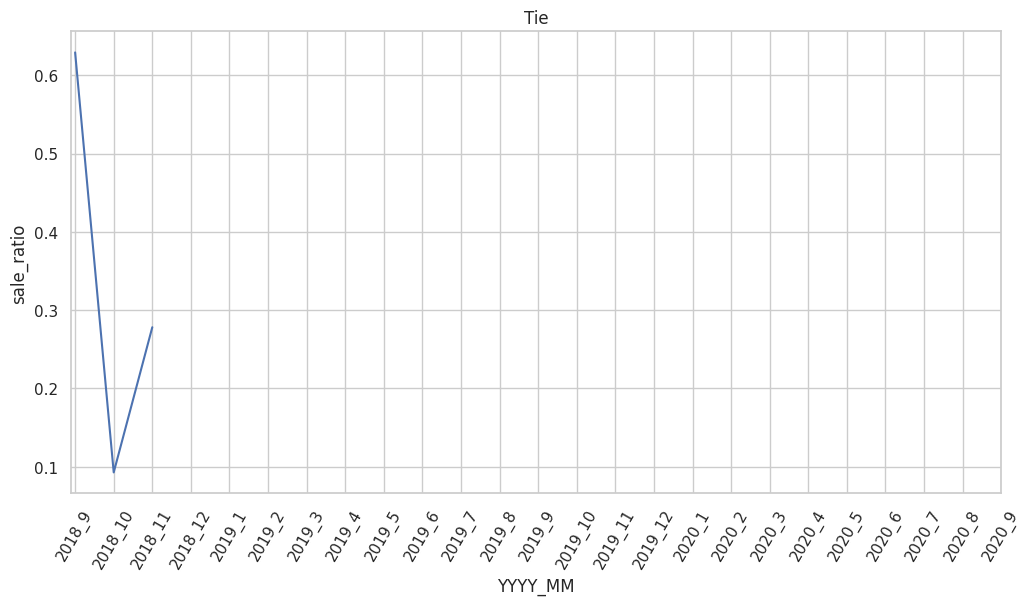

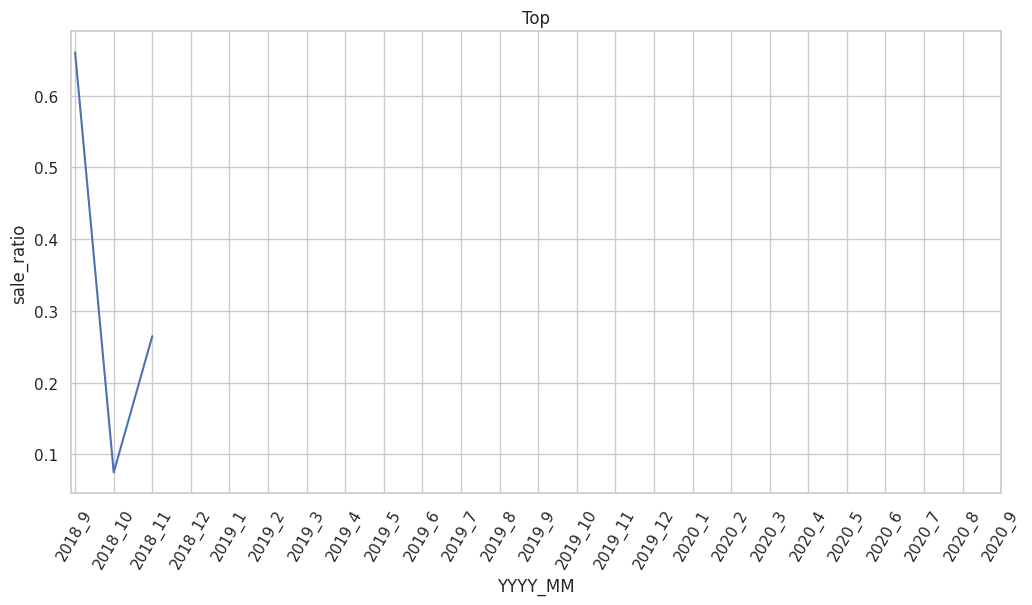

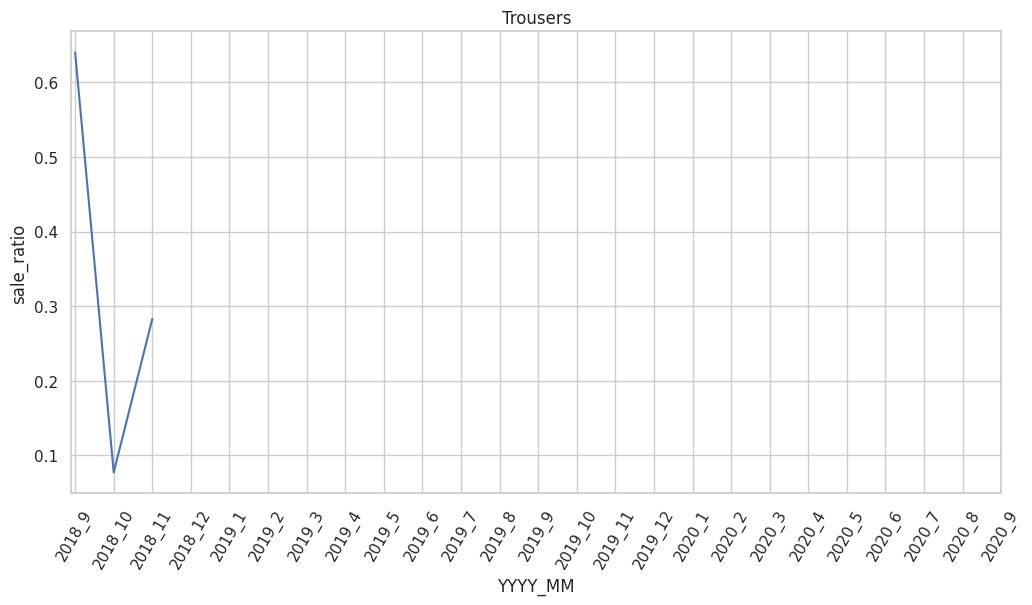

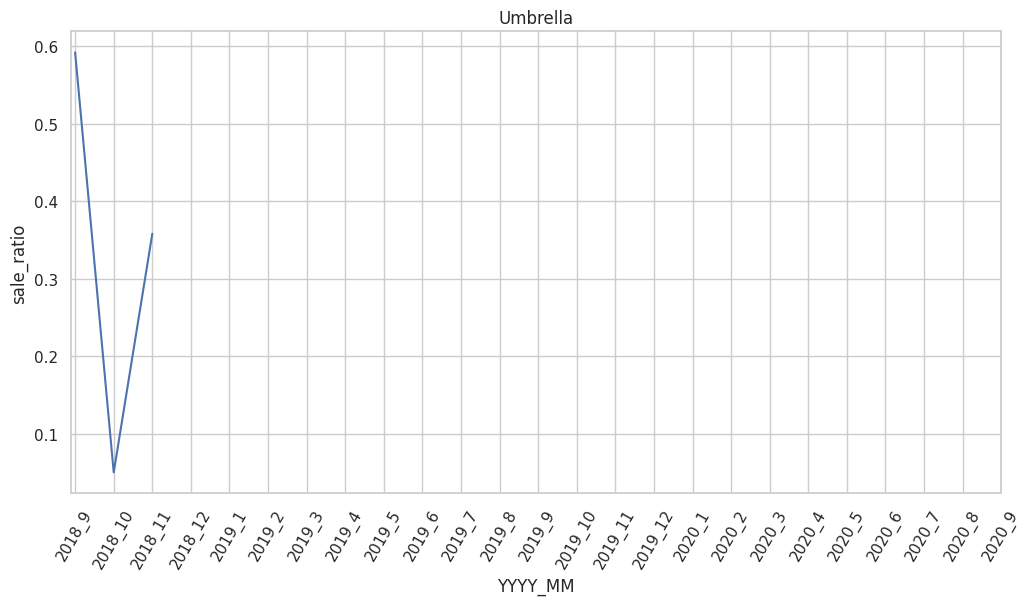

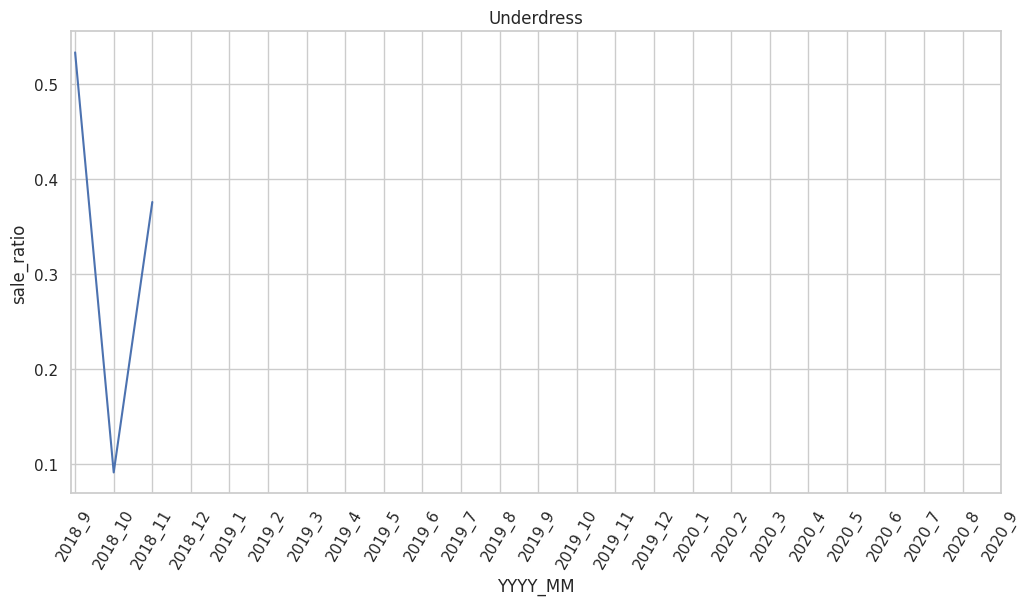

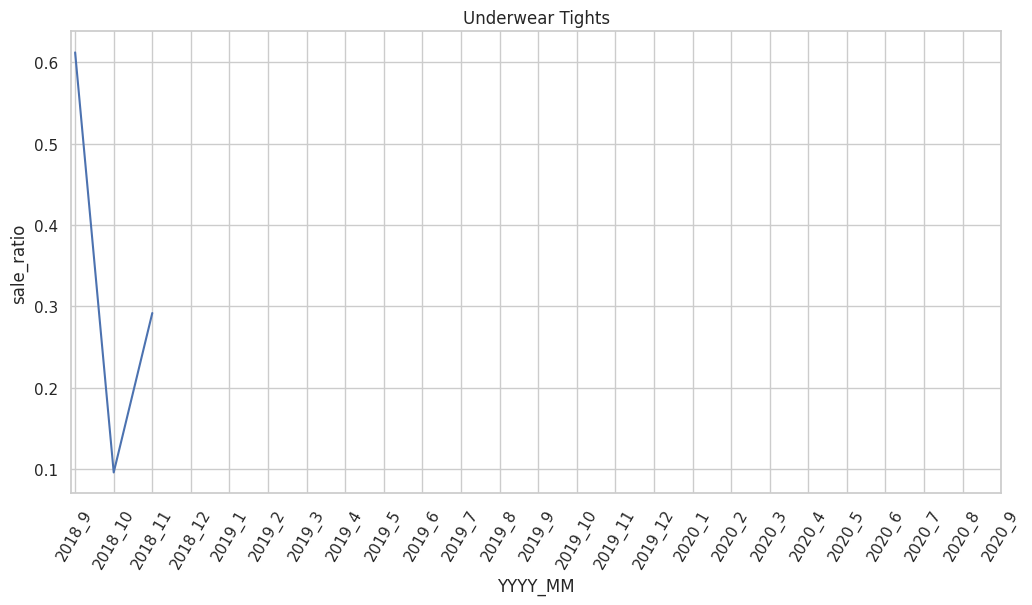

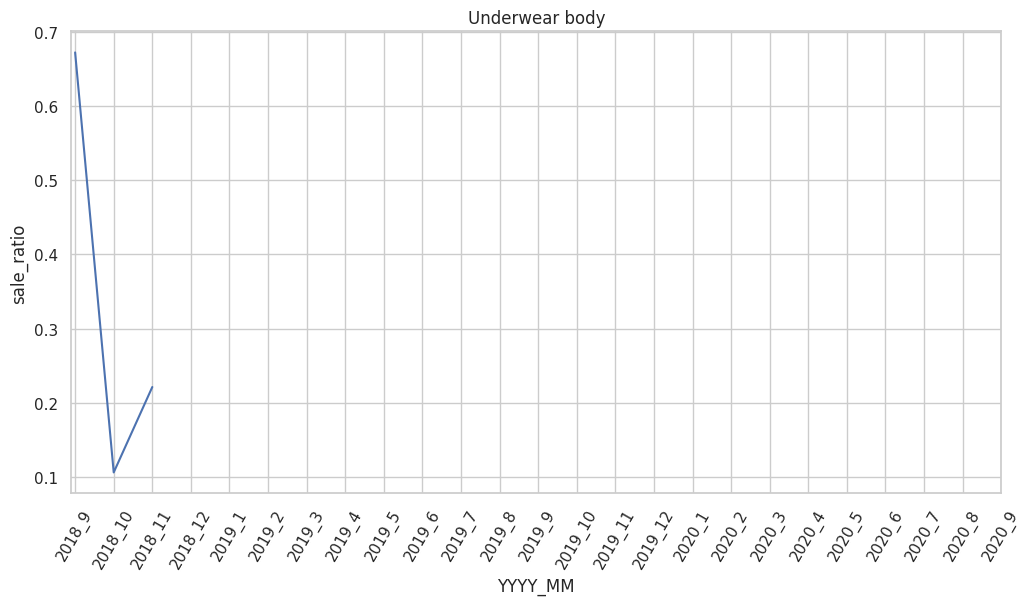

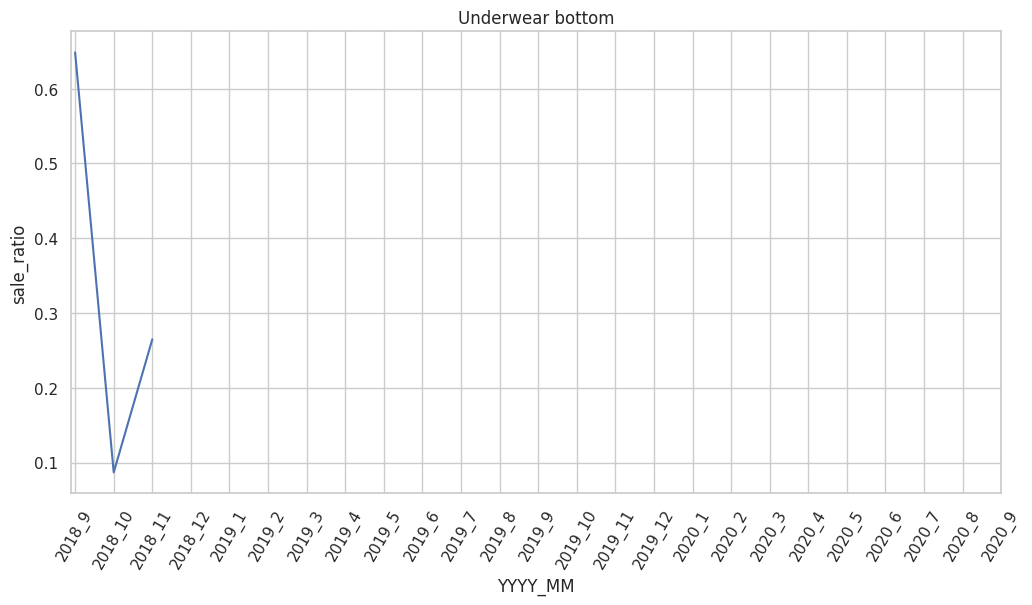

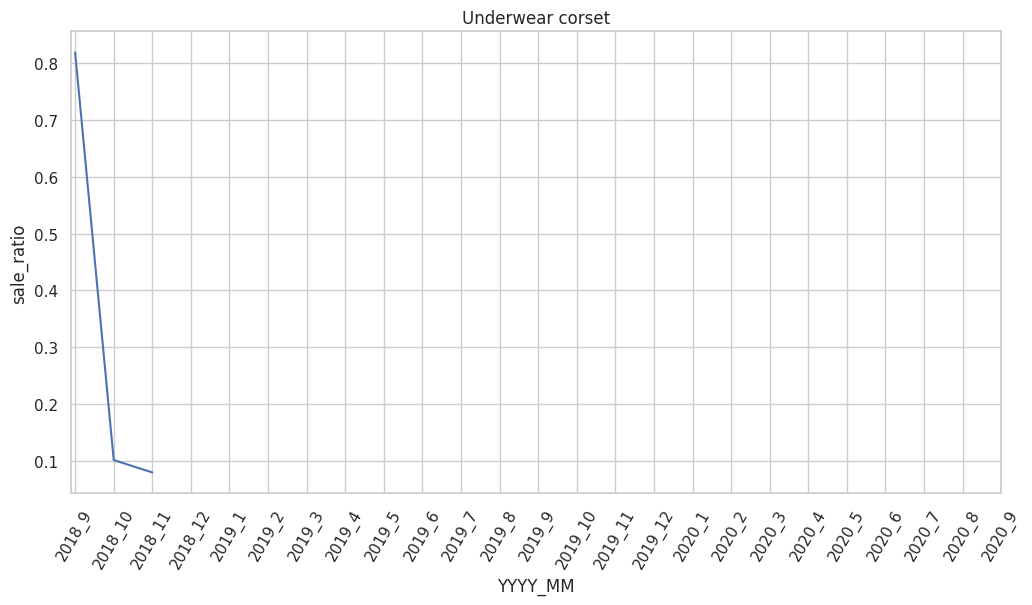

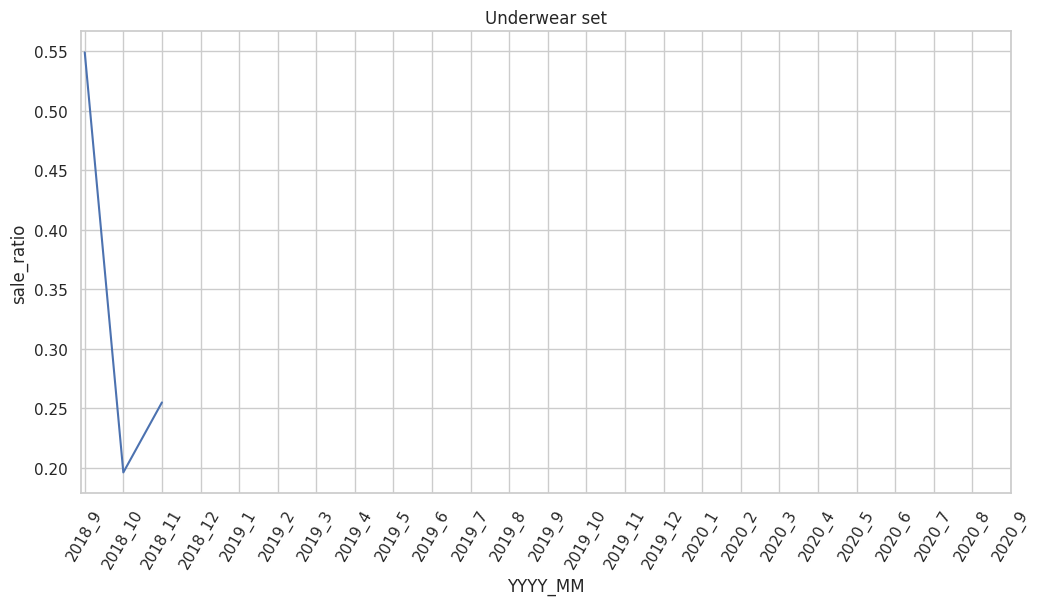

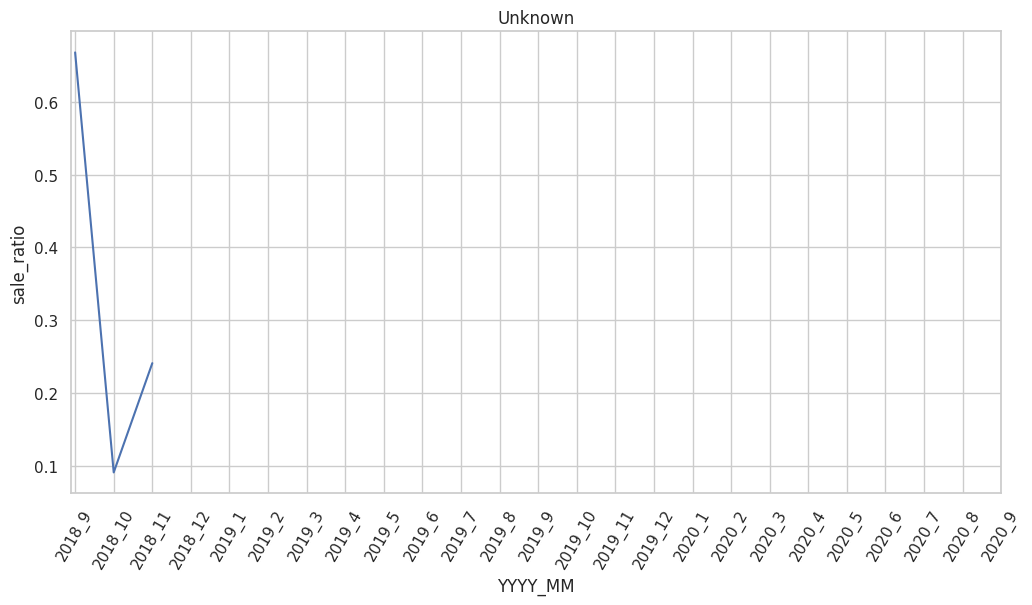

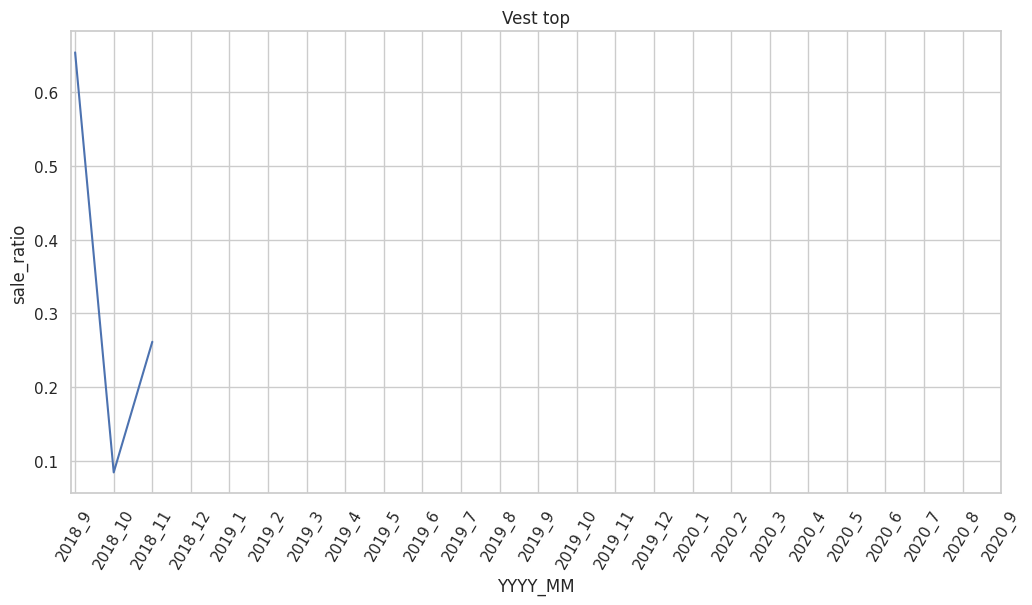

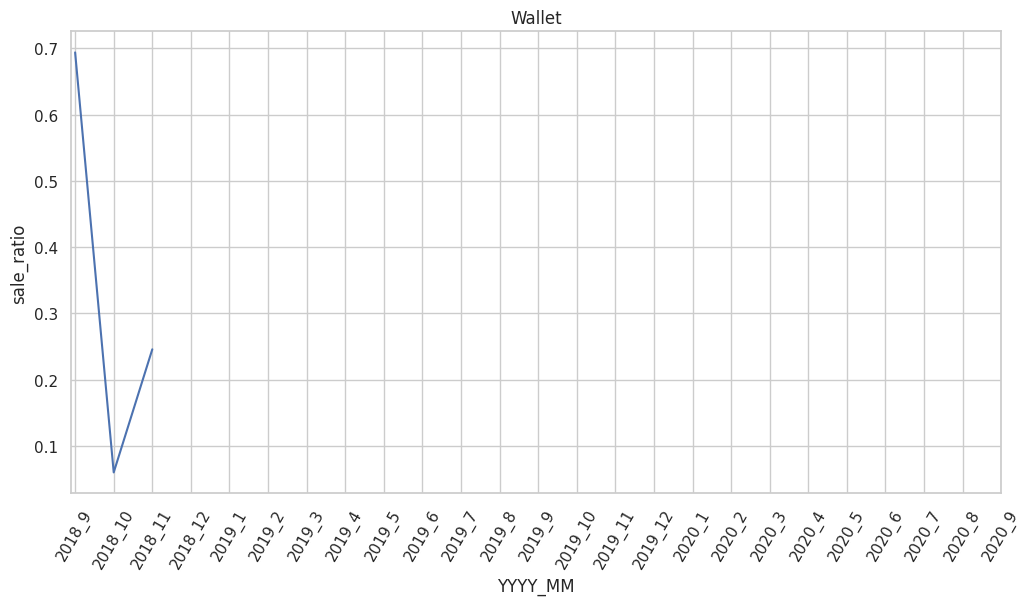

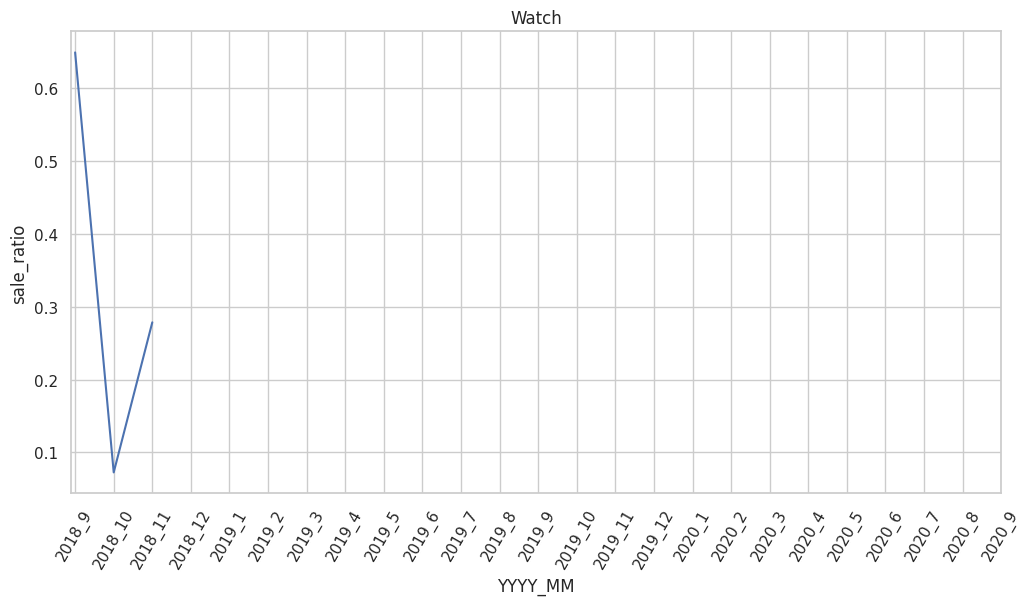

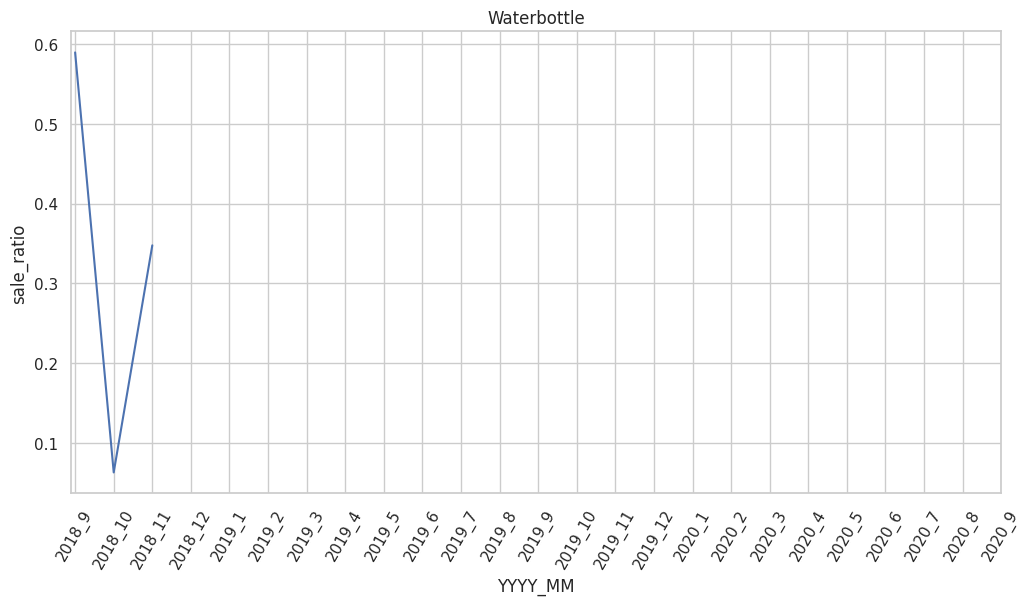

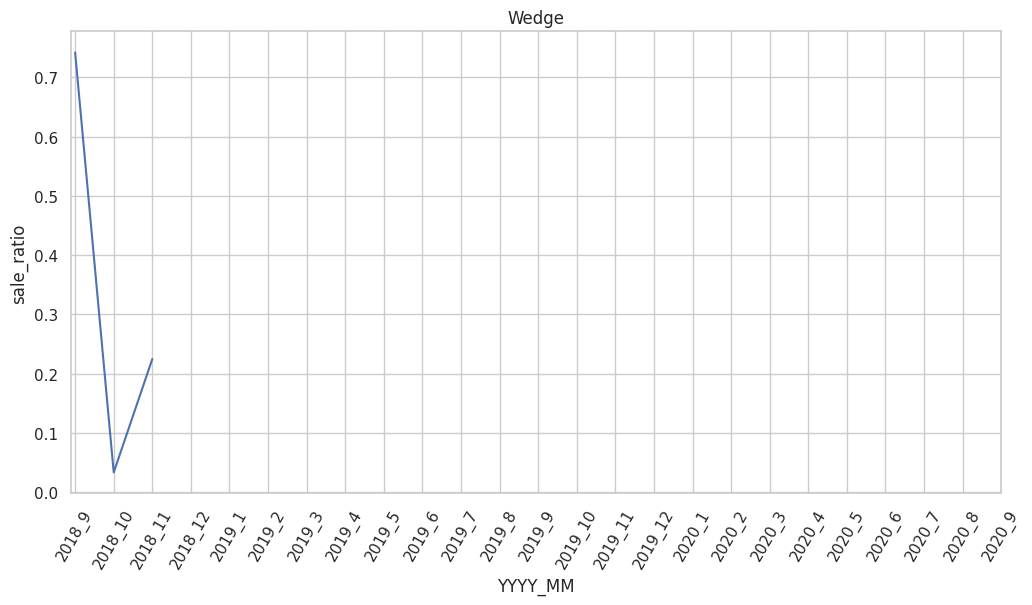

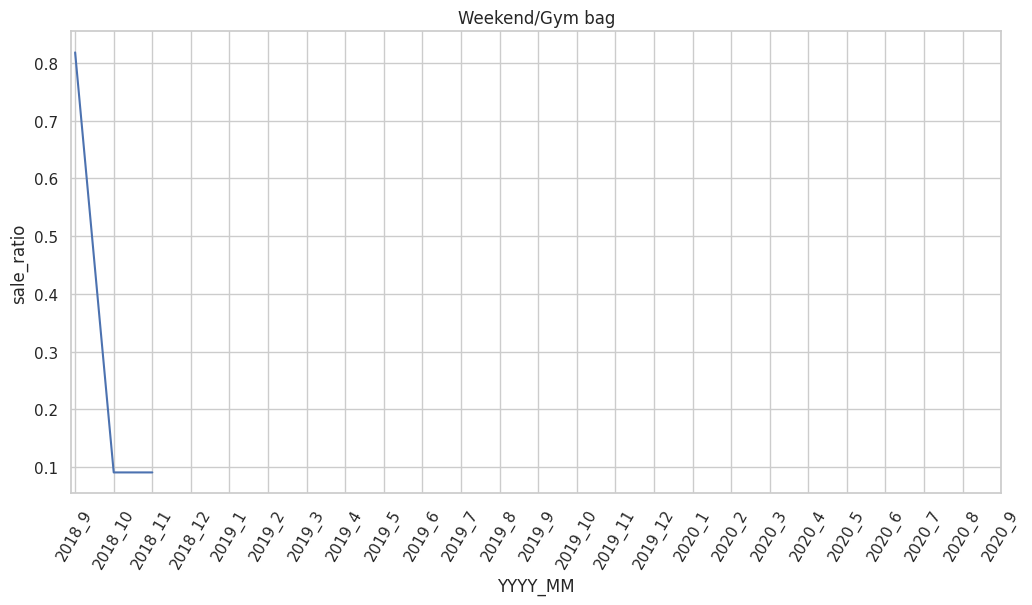

In [27]:
for name in month_sale['product_type_name'].unique():
    tmp = month_sale[month_sale['product_type_name']==name]
    plt.figure(figsize=(12,6))
    sns.lineplot(x='YYYY_MM', y='sale_ratio', data=tmp)
    month = [
        "2018_9",
        "2018_10",
        "2018_11",
        "2018_12",
        "2019_1",
        "2019_2",
        "2019_3",
        "2019_4",
        "2019_5",
        "2019_6",
        "2019_7",
        "2019_8",
        "2019_9",
        "2019_10",
        "2019_11",
        "2019_12",
        "2020_1",
        "2020_2",
        "2020_3",
        "2020_4",
        "2020_5",
        "2020_6",
        "2020_7",
        "2020_8",
        "2020_9",
    ]
    plt.xticks(range(len(month)), month, rotation=60)
    plt.title(name)
    plt.show()
# for name in week_sale['product_type_name'].unique():
#     tmp = week_sale[week_sale['product_type_name']==name]
#     plt.figure(figsize=(12,6))
#     sns.lineplot(x='week', y='sale_ratio', data=tmp)
#     plt.xticks(rotation=60)
#     plt.title(name)
#     plt.show()

Season

In [28]:
summer = [
    "Sunglasses",
    "Hat/brim",
    "Sandals",
    "Flat shoe",
    "Heeled sandals",
    "Polo shirt",
    "Dress",
    "T-shirt",
    "Skirt",
    "Vest top",
    "Swimwear top",
    "Swimsuit",
    "Swimwear bottom",
    "Bikini top",
    "Shorts",
]
winter = [
    "Beanie",
    "Felt hat",
    "Outdoor overall",
    "Long John",
    "Pyjama bottom",
    "Hat/beanie",
    "Leggings/Tights",
    "Hoodie",
    "Underwear Tights",
    "Pyjama set",
    "Boots",
    "Cardigan",
    "Sweater",
    "Jacket",
    "Scarf",
    "Coat",
    "Gloves",
    "Outdoor Waistcoat",
]

In [29]:
month_sale['season_type'] = 0
month_sale.loc[month_sale['product_type_name'].isin(summer), 'season_type'] = 1
month_sale.loc[month_sale['product_type_name'].isin(winter), 'season_type'] = 2
# week_sale['season_type'] = 0
# week_sale.loc[week_sale['product_type_name'].isin(summer), 'season_type'] = 1
# week_sale.loc[week_sale['product_type_name'].isin(winter), 'season_type'] = 2

<ipython-input-30-c7f629644c08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")


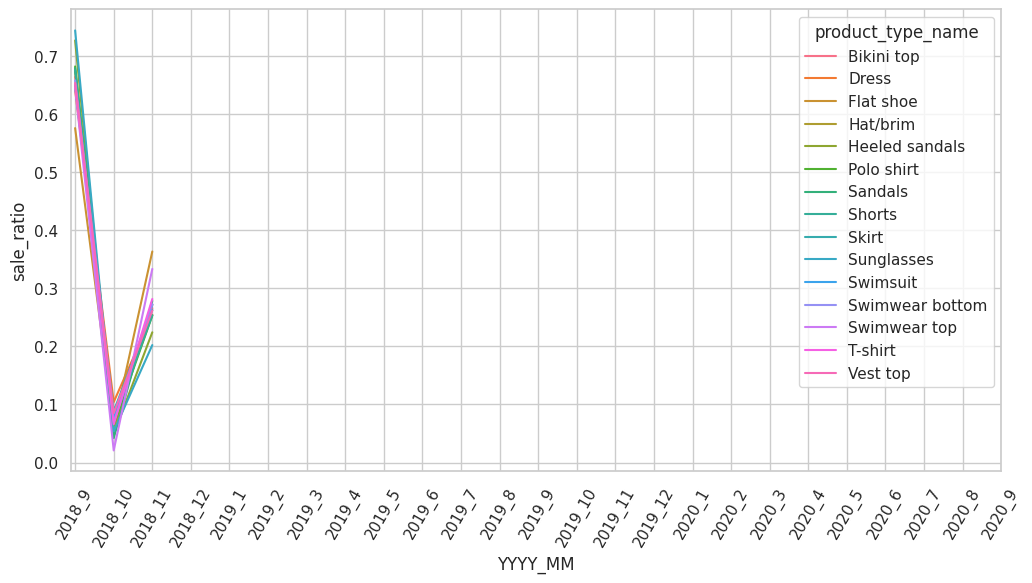

<ipython-input-30-c7f629644c08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")


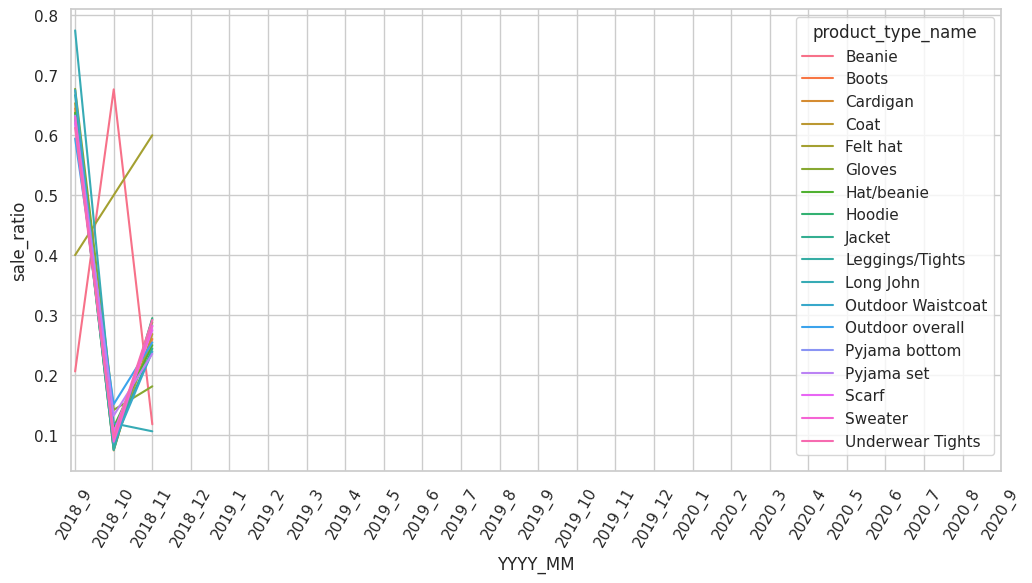

In [30]:
for season_type in [1, 2]:
    tmp = month_sale[month_sale["season_type"] == season_type]
    tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")
    month = [
        "2018_9",
        "2018_10",
        "2018_11",
        "2018_12",
        "2019_1",
        "2019_2",
        "2019_3",
        "2019_4",
        "2019_5",
        "2019_6",
        "2019_7",
        "2019_8",
        "2019_9",
        "2019_10",
        "2019_11",
        "2019_12",
        "2020_1",
        "2020_2",
        "2020_3",
        "2020_4",
        "2020_5",
        "2020_6",
        "2020_7",
        "2020_8",
        "2020_9",
    ]
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="YYYY_MM", y="sale_ratio", data=tmp, hue="product_type_name")
    plt.xticks(range(len(month)), month, rotation=60)
    plt.show()
# for season_type in [1,2]:
#     tmp = week_sale[week_sale['season_type']==season_type]
#     plt.figure(figsize=(12,6))
#     sns.lineplot(x='week', y='sale_ratio', data=tmp, hue='product_type_name')
#     plt.xticks(rotation=60)
#     plt.show()


In [31]:
trans['season_type'] = 0
trans.loc[trans['product_type_name'].isin(summer), 'season_type'] = 1
trans.loc[trans['product_type_name'].isin(winter), 'season_type'] = 2

In [32]:
# * Cover rate
1 - trans[trans['season_type']==0]['article_id'].nunique() / trans['article_id'].nunique()

0.5575426812202631

In [33]:
area_trans = trans[trans['season_type'].isin([1,2])]

In [34]:
area_ttl_sale = area_trans.groupby(['postal_code','season_type']).size().reset_index(name='ttl_sale')
area_sale = area_trans.groupby(['postal_code','YYYY_MM','season_type']).size().reset_index(name='month_sale')
area_sale = area_sale.merge(area_ttl_sale, on=['postal_code','season_type'], how='left')
area_sale['sale_ratio'] = area_sale['month_sale'] / area_sale['ttl_sale']

In [35]:
area_sale['month'] = area_sale['YYYY_MM'].apply(lambda x: int(x.split('_')[1]))
area_sale['season'] = 0
area_sale.loc[area_sale['month'].isin([7,8,9,10]), 'season'] = 1
area_sale.loc[area_sale['month'].isin([12,1,2,3]), 'season'] = 2

In [36]:
season_sale = area_sale.groupby(['postal_code','season_type','season'])['sale_ratio'].sum().reset_index(name='season_sale_ratio')

In [37]:
summer_area_winter_sale = season_sale[(season_sale['season_type']==2) & (season_sale['season']==1)]
winter_area_summer_sale = season_sale[(season_sale['season_type']==1) & (season_sale['season']==2)]

<Axes: >

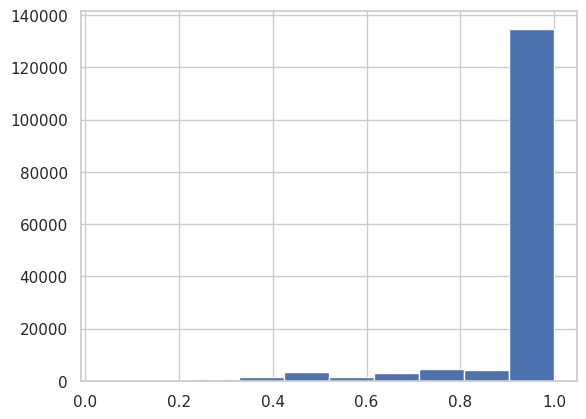

In [38]:
summer_area_winter_sale['season_sale_ratio'].hist()

<Axes: >

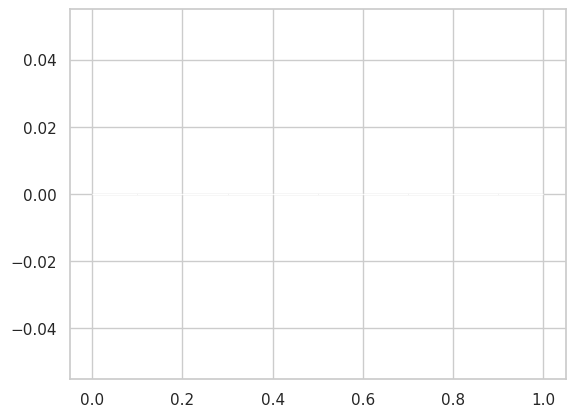

In [39]:
winter_area_summer_sale['season_sale_ratio'].hist()

As we can see, summer cloths are all sold in 'winter' in some area, winter cloths are all sold in 'summer' in some area, are these areas in the Southern Hemisphere?

In [40]:
postal_codes_1 = summer_area_winter_sale[summer_area_winter_sale['season_sale_ratio']>=0.8]['postal_code'].unique()
postal_codes_2 = winter_area_summer_sale[winter_area_summer_sale['season_sale_ratio']>=0.8]['postal_code'].unique()

In [41]:
len(postal_codes_1), len(postal_codes_2)

(140293, 0)

In [42]:
south_areas = set(postal_codes_1) | set(postal_codes_2)

In [43]:
len(south_areas) / trans['postal_code'].nunique()

0.6802876455926993

In [44]:
area_ttl_sale['ttl_sale'].median()

3.0

In [45]:
area_ttl_sale.loc[area_ttl_sale['postal_code'].isin(south_areas),'ttl_sale'].mean()

np.float64(4.478169769246991)